# **INTRODUCTION**
This is the second part of my TTC Subway Delay project.

**Dataset**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import linregress
import textwrap
import calendar
import requests
import json
import io
import geopandas as gpd
from shapely.geometry import shape

In [2]:
df_master = pd.read_excel('Excel Files/df_master.xlsx')
df_master

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,station_clean,line_clean,datetime,time_period,delay_cause,delay_category
0,2024-01-01,02:00,Monday,SHEPPARD STATION,MUI,0,0,N,YU,5491,Sheppard-Yonge,Lines 1 and 4 Shared,2024-01-01 02:00:00,early_morning,Injured or ill Customer (On Train) - Transported,Passenger Related
1,2024-01-01,02:00,Monday,DUNDAS STATION,MUIS,0,0,N,YU,0,Dundas,Line 1 Yonge-University,2024-01-01 02:00:00,early_morning,Injured or ill Customer (In Station) - Transpo...,Passenger Related
2,2024-01-01,02:08,Monday,DUNDAS STATION,MUPAA,4,10,N,YU,6051,Dundas,Line 1 Yonge-University,2024-01-01 02:08:00,early_morning,Passenger Assistance Alarm Activated - No Trou...,Passenger Related
3,2024-01-01,02:13,Monday,KENNEDY BD STATION,PUTDN,10,16,E,BD,5284,Kennedy,Lines 2 and 3 Shared,2024-01-01 02:13:00,early_morning,Debris At Track Level - Uncontrollable,Fortuitous Event
4,2024-01-01,02:22,Monday,BLOOR STATION,MUPAA,4,10,N,YU,5986,Bloor-Yonge,Lines 1 and 2 Shared,2024-01-01 02:22:00,early_morning,Passenger Assistance Alarm Activated - No Trou...,Passenger Related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214456,2017-04-30,19:50,Sunday,BLOOR DANFORTH SUBWAY,MUO,0,0,NaN,BD,0,Bloor-Yonge,Lines 1 and 2 Shared,2017-04-30 19:50:00,evening,Miscellaneous Other,Undefined
214457,2017-04-30,20:25,Sunday,WARDEN STATION,SUDP,4,8,W,BD,5107,Warden,Line 2 Bloor-Danforth,2017-04-30 20:25:00,evening,Disorderly Patron,Passenger Related
214458,2017-04-30,20:29,Sunday,KEELE STATION,SUROB,0,0,NaN,BD,0,Keele,Line 2 Bloor-Danforth,2017-04-30 20:29:00,evening,Robbery,Passenger Related
214459,2017-04-30,22:00,Sunday,YONGE UNIVERSITY LINE,MUO,0,0,NaN,YU/BD,0,Bloor-Yonge,Lines 1 and 2 Shared,2017-04-30 22:00:00,evening,Miscellaneous Other,Undefined


# **EXPLORATORY DATA ANALYSIS - OVERVIEW**

Exploratory analysis on daily delay occurrences and duration, and time of delay, and creation of some functions to streamline EDA.

## Functions and Loops

We'll define some functions here that will speed up our EDA.

In [3]:
# we'll create a dataframe for each delay cause, to help us in creating the charts later
for cause in df_master['delay_cause'].unique():
    if not isinstance(cause, str):
        continue
    subset = df_master[df_master['delay_cause'] == cause]
    cause_df = subset
    # rename each category_df accordingly
    variable_name = cause.replace(" ", "_").replace("/", "_").replace("-", "_").replace("(", "_").replace(")", "_")
    globals()[variable_name] = cause_df

In [4]:
# for a consistent color-scheme per category, we're creating a dictionary here
colors = {'Personnel Related': 'red',
          'Equipment Related': 'orange',
          'Passenger Related': 'green',
          'Fortuitous Event': 'purple',
          'Undefined': 'gray'}

In [5]:
# we'll create a dataframe for each delay category, to help us in creating the charts later
for category in df_master['delay_category'].unique():
    if not isinstance(category, str):
        continue
    subset = df_master[df_master['delay_category'] == category]
    category_df = subset
    # rename each category_df accordingly
    variable_name = category.replace(" ", "_").replace("/", "_").replace("-", "_")
    globals()[variable_name] = category_df

In [6]:
# group into delay category and per month
def grouped_category_monthly(delay_category):
    grouped_category = delay_category.groupby([
        delay_category['delay_cause'],
        delay_category['datetime'].dt.to_period('M').dt.to_timestamp()]).agg(
            total_occurrence = ('Min Delay', 'count'),
            delay_duration = ('Min Delay', 'sum')).reset_index()
    grouped_category['average_delay'] = grouped_category['delay_duration'] / grouped_category['total_occurrence']
    grouped_category['3-Month MA'] = grouped_category['delay_duration'].rolling(window = 3).mean()
    return grouped_category

In [7]:
# group into delay cause per delay category
def grouped_cause_category(delay_category):
    grouped_category = grouped_category_monthly(delay_category)
    grouped_cause = grouped_category.groupby('delay_cause').agg(
        total_occurrence = ('total_occurrence', 'sum'),
        delay_duration = ('delay_duration', 'sum')).reset_index()
    grouped_cause['average_delay'] = grouped_cause['delay_duration'] / grouped_cause['total_occurrence']
    return grouped_cause

In [8]:
# create linear regression table

def linear_regression_table(delay_category):
    grouped_category = grouped_category_monthly(delay_category)
    # create a new column to convert datetime column from datetime data type to numeric data type
    grouped_category['datetime_numeric'] = grouped_category['datetime'].apply(lambda x: x.timestamp())
    
    # perform linear regression
    results = []
    plt.figure(figsize = (15,8))
    for cause in grouped_category['delay_cause'].unique():
        subset = grouped_category[grouped_category['delay_cause'] == cause]
        if len(subset) < 2 or subset['datetime_numeric'].var() == 0 or subset['delay_duration'].var() == 0:
            continue
        slope, intercept, r_value, p_value, std_err = linregress(subset['datetime_numeric'], subset['delay_duration'])
        predicted_y = slope * subset['datetime_numeric'] + intercept
        significance = 'Y' if p_value < 0.05 else 'N'
        strong_significance = 'Y' if p_value < 0.01 else 'N'
    
        # create a table
        results.append({
            'delay_cause': cause,
            'slope': slope,
            'intercept': intercept,
            'r-value': r_value,
            'p-value': p_value,
            'std_err': std_err,
            'pval < 0.05': significance,
            'pval < 0.01': strong_significance})

    # create a dataframe from the list to enable sorting of values
    results = pd.DataFrame(results)
    results_10 = results[results['pval < 0.01'] == 'Y'].sort_values(by = 'slope', ascending = False).head(10)
    return results_10

In [9]:
# plot linear regression

def linear_regression_plot(delay_category):
    grouped_category = grouped_category_monthly(delay_category)
    # create a new column to convert datetime column from datetime data type to numeric data type
    grouped_category['datetime_numeric'] = grouped_category['datetime'].apply(lambda x: x.timestamp())
    
    # perform linear regression
    results = []
    plt.figure(figsize = (15,8))
    for cause in grouped_category['delay_cause'].unique():
        subset = grouped_category[grouped_category['delay_cause'] == cause]
        if len(subset) < 2 or subset['datetime_numeric'].var() == 0 or subset['delay_duration'].var() == 0:
            continue
        slope, intercept, r_value, p_value, std_err = linregress(subset['datetime_numeric'], subset['delay_duration'])
        predicted_y = slope * subset['datetime_numeric'] + intercept
        significance = 'Y' if p_value < 0.05 else 'N'
        strong_significance = 'Y' if p_value < 0.01 else 'N'
    
        # create a table
        results.append({
            'delay_cause': cause,
            'slope': slope,
            'intercept': intercept,
            'r-value': r_value,
            'p-value': p_value,
            'std_err': std_err,
            'pval < 0.05': significance,
            'pval < 0.01': strong_significance})
    
        # plot the regression line per delay cause
        plt.plot(subset['datetime_numeric'], 
            predicted_y, 
            label = f'{cause} - Regression Line', 
            linestyle = '--')

    # create a dataframe from the list to enable sorting of values
    results = pd.DataFrame(results)
    results_10 = results[results['pval < 0.01'] == 'Y'].sort_values(by = 'slope', ascending = False).head(10)

    # annotate the top 10 delay causes in terms of slope (only label causes which are strongly statistically significant)
    for i, row in results_10.iterrows():
        subset = grouped_category[grouped_category['delay_cause'] == row['delay_cause']]
        max_x = subset['datetime_numeric'].max()
        max_y = row['slope'] * max_x + row['intercept']

        plt.annotate(f"{row['delay_cause']}",
            xy = (max_x, max_y), 
            xytext = (max_x + 10000000, max_y + 0),
            arrowprops = dict(arrowstyle = "->", color = 'black'),
            fontsize = 6)

    plt.xlabel('Date (Numeric)')
    plt.ylabel('Delay Duration (in Minutes)')
    plt.title('Linear Regression of Duration of Delay Causes')
    plt.grid(axis = 'y')
    plt.tight_layout()
    plt.show()

In [10]:
# create bar chart (time period)
def create_bar_chart(delay_cause,
                     title = None):
    grouped_data = delay_cause.groupby(['time_period']).agg(
        total_occurrence = ('Min Delay', 'count'),
        delay_duration = ('Min Delay', 'sum')).reset_index()
    
    plt.figure(figsize = (12,5))
    x = np.arange(len(grouped_data['time_period']))
    bars1 = plt.bar(x - 0.35/2,
        grouped_data['delay_duration'],
        0.35,
        label = 'Delay Duration (in Minutes)')
    bars2 = plt.bar(x + 0.35/2,
        grouped_data['total_occurrence'],
        0.35,
        label = 'Delay Occurrence (Count)',
        color = 'orange')

    # Annotate the bars
    for bar in bars1:
        plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height(), 
             f'{bar.get_height():.0f} (Minutes)', 
             ha = 'center', va = 'bottom', fontsize = 10)

    for bar in bars2:
        plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height(), 
             f'{bar.get_height():.0f} (Count)', 
             ha = 'center', va = 'bottom', fontsize = 10)
        
    # Add labels and title
    plt.title(title)
    plt.xlabel('Time Period')
    plt.xticks(x, grouped_data['time_period'])
    plt.legend()
    plt.tight_layout()
    plt.show()

In [11]:
# create histogram on Min Delay per Delay Cause
def create_histogram(delay_cause,
                     title = None):
        plt.figure(figsize = (15, 2))
        plt.hist(delay_cause['Min Delay'], 
             bins = 100, 
             color = 'blue', 
             edgecolor = 'black', 
             alpha = 0.7)
        plt.title(title)
        plt.xlabel('Delay Duration (in Minutes)')
        plt.ylabel('Frequency')
        plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
        plt.show()

## Daily Delay Occurrences

Delay Occurrences is the count or number of recorded delays in a given time period.

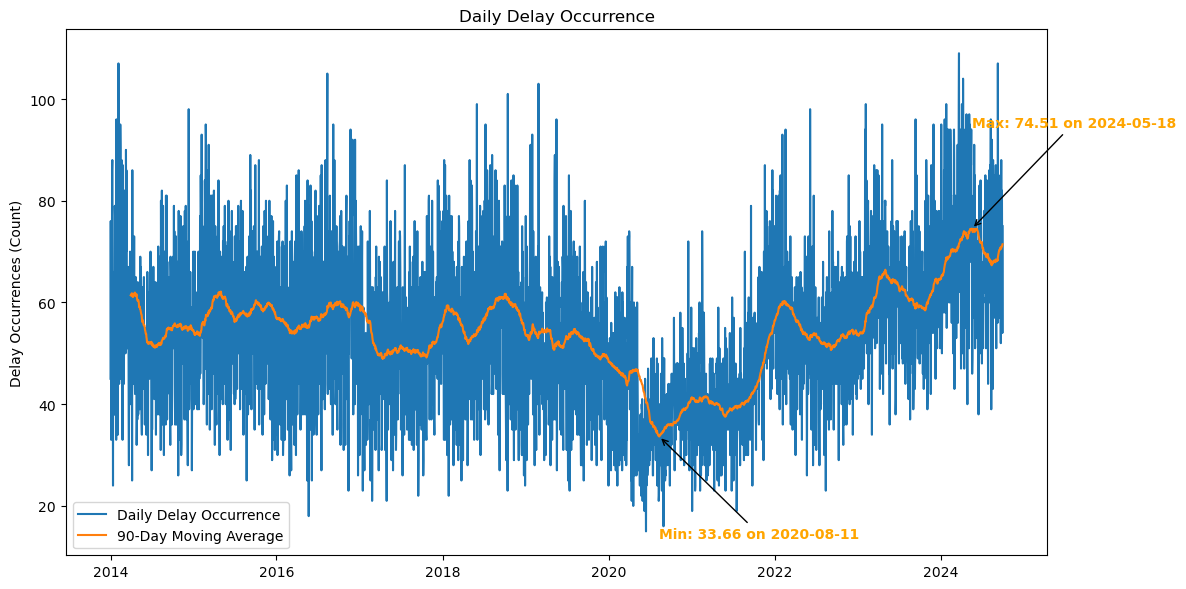

In [12]:
# group by date and count the delay occurrences
daily_delay_occurrence = df_master.groupby('Date')['Min Delay'].count().reset_index()
# compute the 90-day moving average
daily_delay_occurrence['MA90'] = daily_delay_occurrence['Min Delay'].rolling(window = 90).mean()

# create the line chart
plt.figure(figsize = (12,6))
plt.plot(daily_delay_occurrence['Date'], 
         daily_delay_occurrence['Min Delay'], 
         label = 'Daily Delay Occurrence')
plt.plot(daily_delay_occurrence['Date'], 
         daily_delay_occurrence['MA90'], 
         label = '90-Day Moving Average')
plt.title('Daily Delay Occurrence')
plt.ylabel('Delay Occurrences (Count)')

# annotate max values
max_date = daily_delay_occurrence.loc[daily_delay_occurrence['MA90'].idxmax(), 'Date']
max_delay = daily_delay_occurrence['MA90'].max()
plt.annotate(f'Max: {max_delay:.2f} on {max_date.strftime("%Y-%m-%d")}',
             xy = (max_date, max_delay), 
             xytext = (max_date, max_delay + 20),
             arrowprops = dict(arrowstyle = '->'), 
             fontsize = 10, 
             color = 'orange', 
             fontweight = 'bold')

# annotate min values
min_date = daily_delay_occurrence.loc[daily_delay_occurrence['MA90'].idxmin(), 'Date']
min_delay = daily_delay_occurrence['MA90'].min()
plt.annotate(f'Min: {min_delay:.2f} on {min_date.strftime("%Y-%m-%d")}',
             xy = (min_date, min_delay), 
             xytext = (min_date, min_delay - 20),
             arrowprops = dict(arrowstyle = '->'), 
             fontsize = 10, 
             color = 'orange', 
             fontweight = 'bold')

plt.legend()
plt.tight_layout()
plt.show()

The number of delays markedly decreased during the pandemic period, from the first quarter of 2020 to the end of 2021. Notably, post-pandemic averages saw an increasing trend, which mean that delays have been getting more frequent compared to pre-pandemic trends.

One important thing to note here, however, is that the dataset includes delay instances that lasted for less than a minute. The TTC marks these as delay occurrences even if they lasted for only several seconds, such as whenever the train has to slow its speed due to 'Miscellaneous' reasons. Therefore, the increasing occurrences might not necessarily mean that TTC's operations are getting worse.

The increasing trend post-pandemic in itself is inconclusive, as this may also indicate better recording practices by TTC from a data collection perspective.

## Daily Delay Duration

Delay Duration is the sum of the length (duration) of recorded delays, as recorded under the 'Min Delay' column of the data frame, in a given time period.

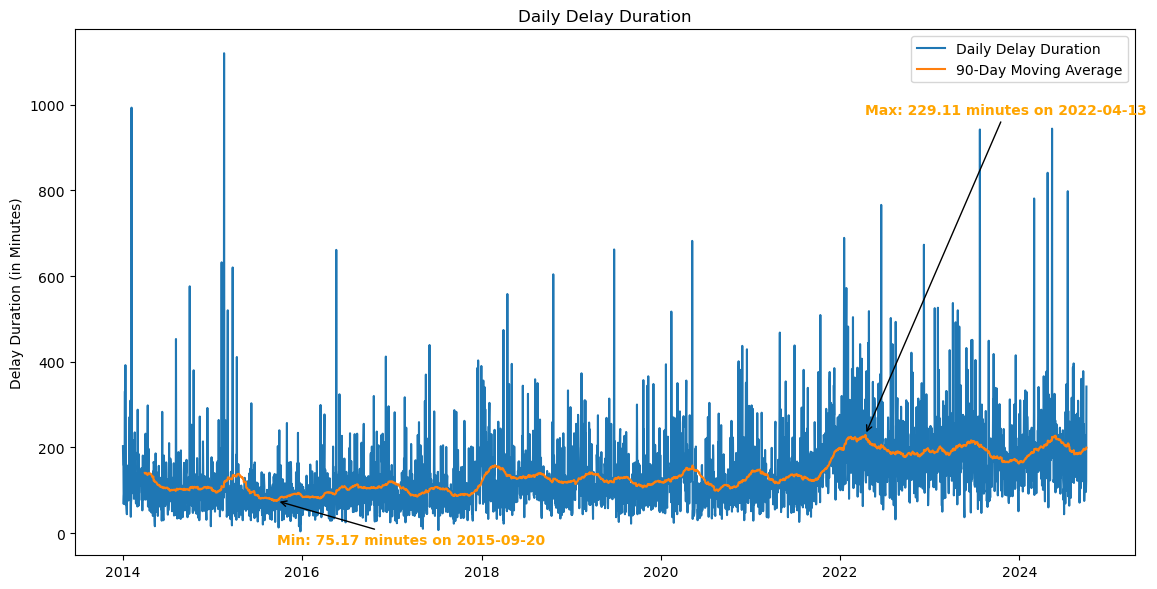

In [13]:
# group by date and sum the delay occurrences
daily_delay_duration = df_master.groupby('Date')['Min Delay'].sum().reset_index()
# compute the 90-day moving average
daily_delay_duration['MA90'] = daily_delay_duration['Min Delay'].rolling(window = 90).mean()

# create the line chart
plt.figure(figsize = (12,6))
plt.plot(daily_delay_duration['Date'], 
         daily_delay_duration['Min Delay'], 
         label = 'Daily Delay Duration')
plt.plot(daily_delay_duration['Date'], 
         daily_delay_duration['MA90'], 
         label = '90-Day Moving Average')
plt.title('Daily Delay Duration')
plt.ylabel('Delay Duration (in Minutes)')

# annotate max values
max_date = daily_delay_duration.loc[daily_delay_duration['MA90'].idxmax(), 'Date']
max_delay = daily_delay_duration['MA90'].max()
plt.annotate(f'Max: {max_delay:.2f} minutes on {max_date.strftime("%Y-%m-%d")}',
             xy = (max_date, max_delay), 
             xytext = (max_date, max_delay + 750),
             arrowprops = dict(arrowstyle = '->'), 
             fontsize = 10, 
             color = 'orange', 
             fontweight = 'bold')

# annotate min values
min_date = daily_delay_duration.loc[daily_delay_duration['MA90'].idxmin(), 'Date']
min_delay = daily_delay_duration['MA90'].min()
plt.annotate(f'Min: {min_delay:.2f} minutes on {min_date.strftime("%Y-%m-%d")}',
             xy = (min_date, min_delay), 
             xytext = (min_date, min_delay - 100),
             arrowprops = dict(arrowstyle = '->'), 
             fontsize = 10, 
             color = 'orange', 
             fontweight = 'bold')

plt.legend()
plt.tight_layout()
plt.show()


We see a more conclusive observation here: total delays per day have been lasting longer.

An escalation in the 90-day Moving Average Delay Duration (MADD) was seen in late 2017, which plateaued from early 2018 to the first quarter of 2020. The beginning of the Covid-19 pandemic in the second quarter of 2020 reduced delay durations because of limited subway operations due to lockdowns. However, upon reopening of the economy sometime in late 2021, 90-day MADD began ascending and peaked on February 12, 2022 at 229.11 minutes (3.8 hours) on a single day. The 90-day MADD plateaued once more after this date, notably at a higher level compared to that during the pandemic and pre-pandemic periods.

## Time of Delay

Total of delay durations by minute.

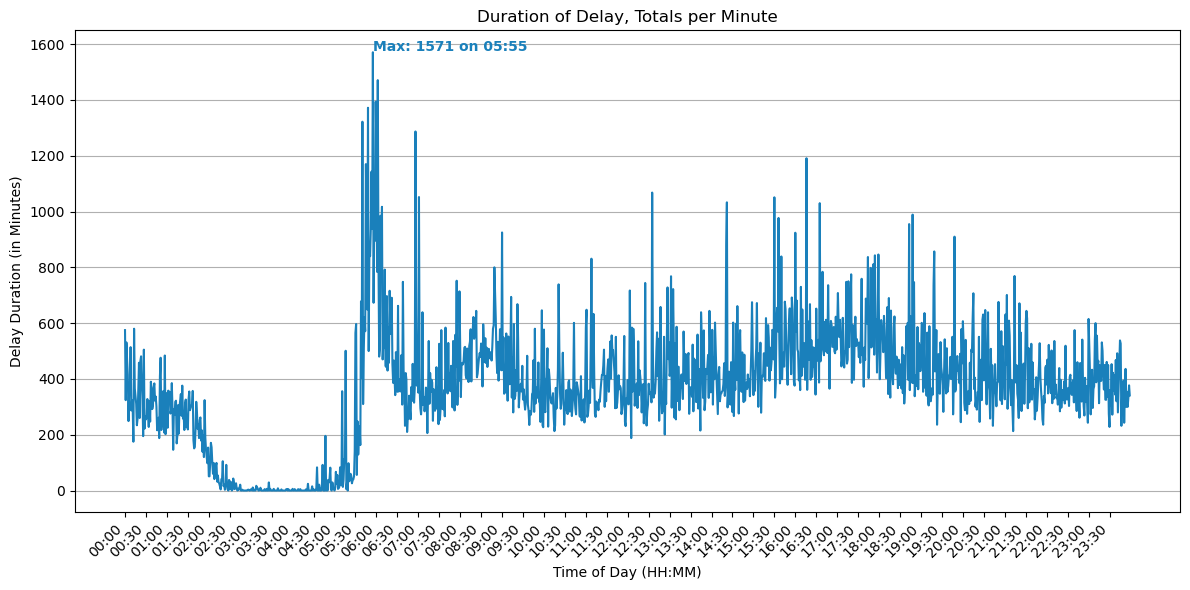

In [14]:
# group by time and sum the delay duration
delay_duration_per_minute = df_master.groupby('Time')['Min Delay'].sum().reset_index()

# create the line chart
plt.figure(figsize=(12, 6))
plt.plot(delay_duration_per_minute['Time'], 
         delay_duration_per_minute['Min Delay'], 
         color='#1a80bb')
plt.title('Duration of Delay, Totals per Minute')
plt.xlabel('Time of Day (HH:MM)')
plt.xticks(delay_duration_per_minute['Time'][::30], rotation = 45, ha = 'right')
plt.ylabel('Delay Duration (in Minutes)')
plt.grid(axis = 'y')

# maximum data annotation
max_time = delay_duration_per_minute.loc[delay_duration_per_minute['Min Delay'].idxmax(), 'Time']
max_delay = delay_duration_per_minute['Min Delay'].max()
plt.annotate(f'Max: {max_delay} on {max_time}',
             xy = (max_time, max_delay), 
             xytext = (max_time, max_delay + 5),
             fontsize = 10, 
             color = '#1a80bb', 
             fontweight = 'bold')

plt.tight_layout()
plt.show()

When delay durations are totaled per minute, 05:55 (5:55 am) had the longest delays. This is a critical time for TTC commuters as this may represent a time when people are on their way to their workplaces.

# **EXPLORATORY DATA ANALYSIS - DELAY CAUSES**

Exploratory analysis on delay categories and causes.

## Delay Causes

One of the primary objectives of this paper is to determine whether we can improve the efficiency and reliability of the TTC Subway System. As shown previously, there are 200 delay causes identified by the TTC in its excel file (they separated the delay causes between Lines 1, 2, and 4, and Line 3; a number of causes are identical between them), out of which 143 were present in the cleaned dataset. This poses a huge problem in our data analysis.

In [15]:
# group by delay_cause and create a table with count, sum, average, and delay_category
grouped_delay_causes = df_master.groupby('delay_cause').agg(
    total_occurrence = ('Min Delay', 'count'),
    delay_duration = ('Min Delay', 'sum'),
    delay_category = ('delay_category', 'first')).reset_index()
grouped_delay_causes['average_delay'] = grouped_delay_causes['delay_duration'] / grouped_delay_causes['total_occurrence']
grouped_delay_causes

,delay_cause,total_occurrence,delay_duration,delay_category,average_delay
0,ATC Operator Related,342,1467,Personnel Related,4.289474
1,ATC Project,3302,15434,Equipment Related,4.674137
2,ATC RC&S Equipment,124,644,Equipment Related,5.193548
3,ATC Signals Other,54,132,Equipment Related,2.444444
4,Air Conditioning,361,1518,Equipment Related,4.204986
...,...,...,...,...,...
138,Work Refusal,221,786,Personnel Related,3.556561
139,Work Vehicle,153,1993,Equipment Related,13.026144
140,Work Zone Problems - Signals,105,562,Equipment Related,5.352381
141,Work Zone Problems - Track,581,6020,Equipment Related,10.361446


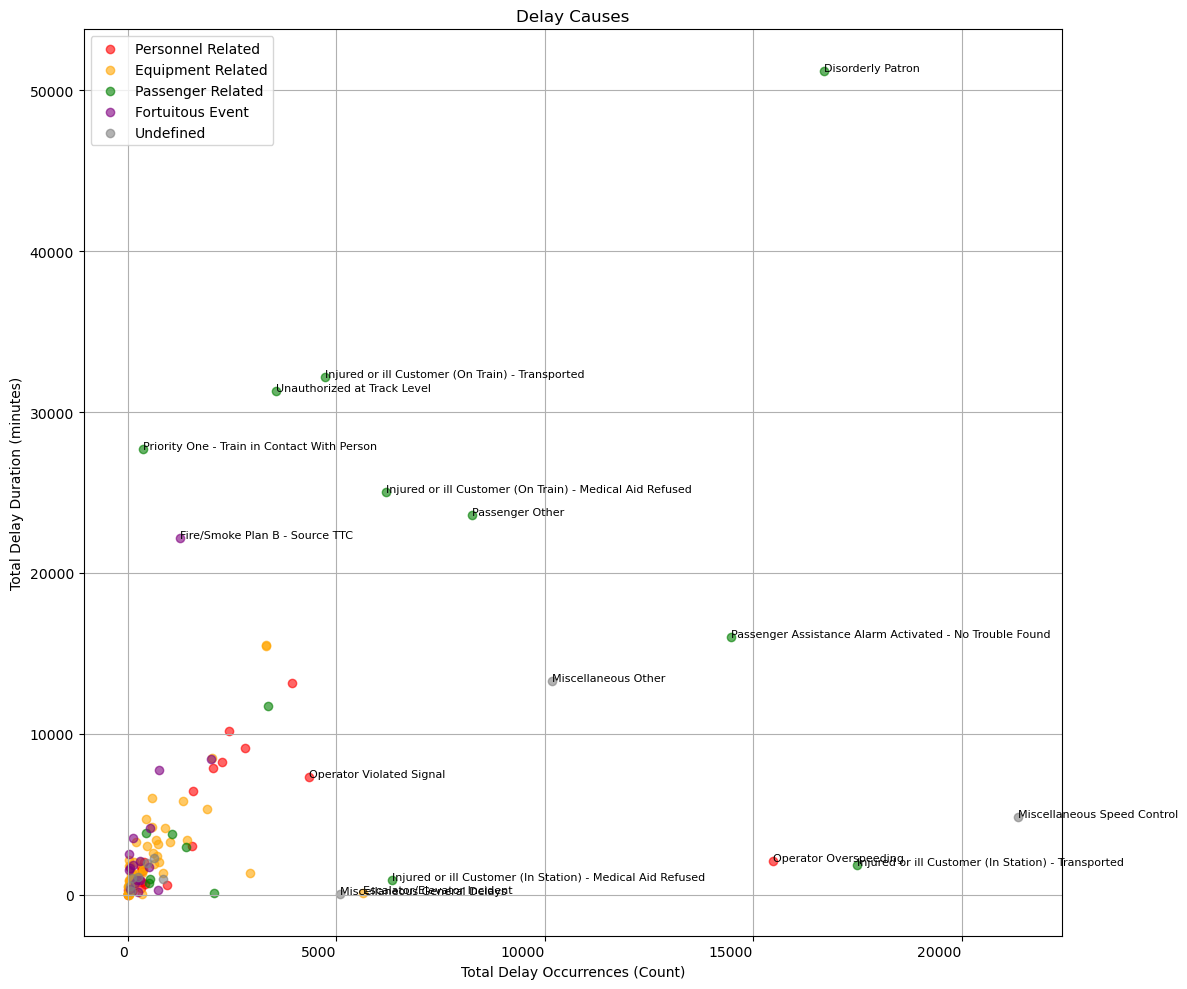

In [16]:
# create scatterplot per delay_cause and implement color scheme per delay_category
plt.figure(figsize = (12, 10))
for category, color in colors.items():
    subset = grouped_delay_causes[grouped_delay_causes['delay_category'] == category]
    plt.scatter(subset['total_occurrence'],
                subset['delay_duration'],
                #s = subset['average_delay'] * 10,
                alpha = 0.6,
                label = category,
                c = color)

# annotate data that meets criteria below
for i, row in grouped_delay_causes[
    (grouped_delay_causes['total_occurrence'] > 4000) |
    (grouped_delay_causes['delay_duration'] > 20000)].iterrows():
    plt.annotate(row['delay_cause'], 
                (row['total_occurrence'], row['delay_duration']), 
                fontsize = 8)

plt.title('Delay Causes')
plt.xlabel('Total Delay Occurrences (Count)')
plt.ylabel('Total Delay Duration (minutes)')
plt.xticks(rotation = 0, ha = 'right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Here we classify delays in terms of risk management:
1. Unlikely Bother, or Low-Likelihood Low-Severity delays
 - These are delay causes that are not frequent and also with low delay duration. They almost never happen and, if they do, have very little impact and can easily be rectified. In our scatterplot above, these are the delay causes that occupy the lower left quadrant (less than 20,000 minutes duration and less than 10,000 occurrences): 'Operator Violated Signal', 'Injured or ill Customer (in Station) - Medical Aid Refused', 'Escalator/Elevator Incident', etc. We can see from our plot above that majority of recorded delays fall within this classification.

2. Frequent Nuisance, or High-Likelihood Low-Severity delays
 - These are delay causes that are frequent but with low delay duration. These include minor equipment malfunctions that are resolved quickly, routine maintenance issues, etc. In our scatterplot above, these are the delay causes that occupy the lower right quadrant (less than 20,000 minutes duration and more than 10,000 occurrences): 'Miscellaneous Speed Control', 'Operator Overspeeding', 'Injured or ill Customer (In Station) - Transported', 'Passenger Assistance Alarm Activated - No Trouble Found', 'Miscellaneous Other', etc.

3. Black Swans, or Low-Likelihood High-Severity delays
 - In risk management, this is any event that is rare but with severe consequences. Delay causes that are low in terms of delay occurrence but high in delay duration (more than 20,000 minutes duration and less than 10,000 occurrences) are considered Black Swans: 'Injured or ill Customer (On Train) - Medical Aid Refused', 'Injured or ill Customer (On Train) - Transported', 'Unauthorized at Track Level', 'Priority One - Train in Contact with Person', etc.

4. Critical Risk, or High-Likelihood High-Severity delays
 - These are events that are high in both frequency and duration (more than 20,000 minutes duration and more than 10,000 occurrences). A single delay cause falls in this classification: 'Disorderly Patron'.



## Delay Categories

In [17]:
# group into delay category and per month
grouped_delay_category = df_master.groupby([
        df_master['delay_category'],
        df_master['datetime'].dt.to_period('M').dt.to_timestamp()
    ]).agg(
        total_occurrence = ('Min Delay', 'count'),
        delay_duration = ('Min Delay', 'sum')).reset_index()
grouped_delay_category['average_delay'] = grouped_delay_category['delay_duration'] / grouped_delay_category['total_occurrence']
grouped_delay_category['3-Month MA'] = grouped_delay_category['delay_duration'].rolling(window = 3).mean()
grouped_delay_category

,delay_category,datetime,total_occurrence,delay_duration,average_delay,3-Month MA
0,Equipment Related,2014-01-01,372,1467,3.943548,NaN
1,Equipment Related,2014-02-01,293,1054,3.597270,NaN
2,Equipment Related,2014-03-01,347,1385,3.991354,1302.000000
3,Equipment Related,2014-04-01,287,1112,3.874564,1183.666667
4,Equipment Related,2014-05-01,292,992,3.397260,1163.000000
...,...,...,...,...,...,...
640,Undefined,2024-05-01,219,274,1.251142,238.333333
641,Undefined,2024-06-01,175,195,1.114286,227.000000
642,Undefined,2024-07-01,206,184,0.893204,217.666667
643,Undefined,2024-08-01,301,517,1.717608,298.666667


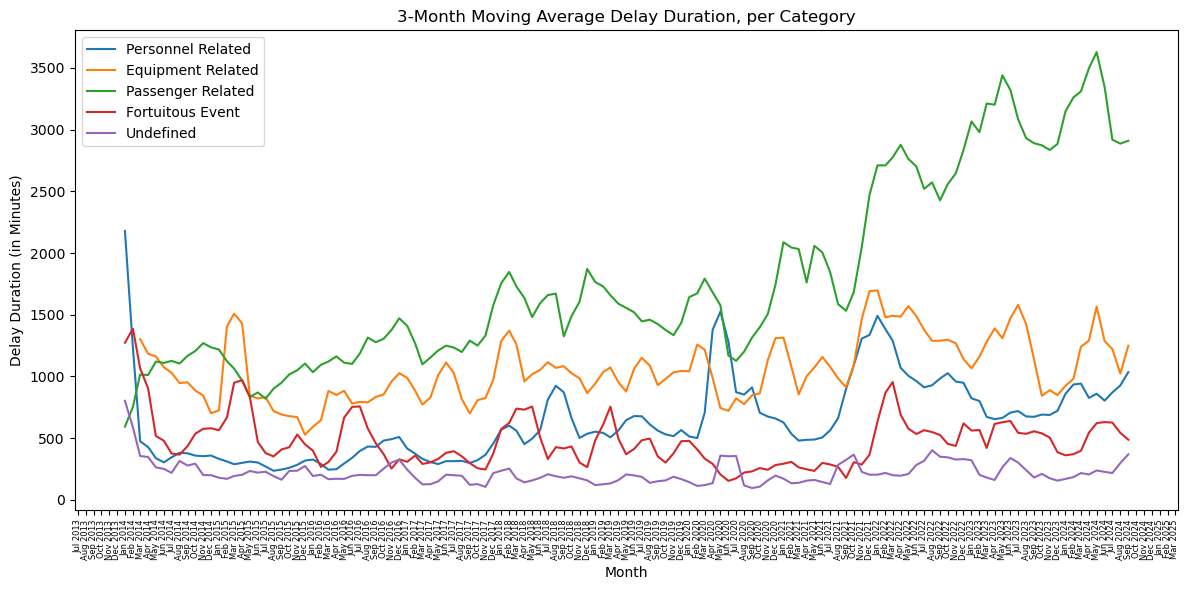

In [18]:
# plot in a line chart to look for trends per delay category using 3-month averages
plt.figure(figsize = (12,6))
for category, color in colors.items():
    subset = grouped_delay_category[grouped_delay_category['delay_category'] == category]
    plt.plot(subset['datetime'], 
             subset['3-Month MA'], 
             label = category)
    
plt.title('3-Month Moving Average Delay Duration, per Category')
plt.xlabel('Month')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation = 90, fontsize = 6)
plt.ylabel('Delay Duration (in Minutes)')
plt.legend()
plt.tight_layout()
plt.show()

Four (4) categories led the initial spike in late 2021: Fortuitous Event, Personnel Related, Equipment Related, and Passenger Related. However, three (3) of the four (4) have since slowly tapered down, save for Passenger Related whose trend continues to worsen.

We can conclude from the above line chart that the worsening 90-day MADD since late 2021 was primarily caused by the worsening of the duration of Passenger-Related delays, as seen in the 3-month MADD above. 

## Passenger Related Category

In [19]:
grouped_category_monthly(delay_category = Passenger_Related)

,delay_cause,datetime,total_occurrence,delay_duration,average_delay,3-Month MA
0,Assault / Employee Involved,2014-01-01,8,9,1.125000,NaN
1,Assault / Employee Involved,2014-02-01,5,6,1.200000,NaN
2,Assault / Employee Involved,2014-03-01,6,11,1.833333,8.666667
3,Assault / Employee Involved,2014-04-01,10,26,2.600000,14.333333
4,Assault / Employee Involved,2014-05-01,6,0,0.000000,12.333333
...,...,...,...,...,...,...
2014,Unauthorized at Track Level,2024-05-01,64,457,7.140625,545.666667
2015,Unauthorized at Track Level,2024-06-01,57,439,7.701754,522.666667
2016,Unauthorized at Track Level,2024-07-01,46,364,7.913043,420.000000
2017,Unauthorized at Track Level,2024-08-01,50,343,6.860000,382.000000


In [20]:
grouped_cause_category(delay_category = Passenger_Related)

,delay_cause,total_occurrence,delay_duration,average_delay
0,Assault / Employee Involved,1401,2962,2.114204
1,Assault / Patron Involved,3358,11714,3.488386
2,Disorderly Patron,16704,51237,3.067349
3,Door Problems - Passenger Related,1054,3775,3.581594
4,Held By Polce - Non-TTC Related,431,3846,8.923434
5,Injured or ill Customer (In Station) - Medical...,6321,918,0.145230
6,Injured or ill Customer (In Station) - Transpo...,17496,1822,0.104138
7,Injured or ill Customer (On Train) - Medical A...,6196,25031,4.039864
8,Injured or ill Customer (On Train) - Transported,4735,32174,6.794931
9,Passenger Assistance Alarm Activated - No Trou...,14462,15984,1.105241


### Linear Regression on Delay Causes under Passenger Related Category

Aside from visually assessing the trend of each delay cause, we can also mathematically check if the delay duration per delay cause is actually getting worse or better. We do this through linear regression. Here, we assign the month as the independent variable and the delay duration as the dependent variable.

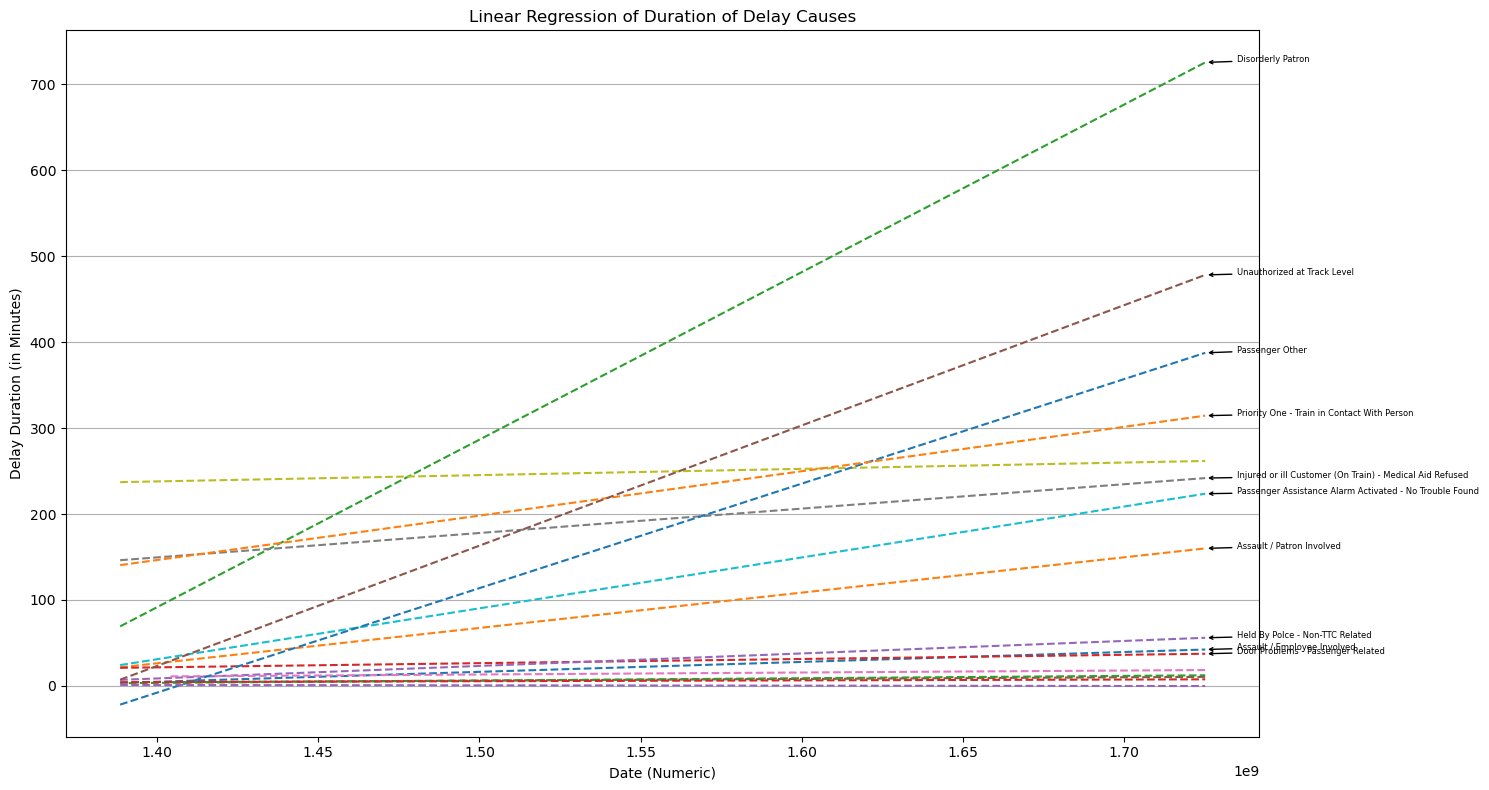

In [21]:
linear_regression_plot(delay_category = Passenger_Related)

A positive slope indicates that the delay duration is getting worse. A negative slope indicates that it is getting better.
A p-value of less than 0.05 means that the change (i.e. the slope, whether positive or negative) is statistically significant. A p-value of equal or more than 0.05 means that the delay duration is getting worse due to random chance.

In [22]:
linear_regression_table(delay_category = Passenger_Related)

,delay_cause,slope,intercept,r-value,p-value,std_err,pval < 0.05,pval < 0.01
2,Disorderly Patron,1.948996e-06,-2636.949192,0.807354,6.995478e-31,1.263998e-07,Y,Y
15,Unauthorized at Track Level,1.398944e-06,-1935.226845,0.783184,5.571025e-28,9.855483e-08,Y,Y
10,Passenger Other,1.215783e-06,-1709.877352,0.722074,4.638521e-22,1.033625e-07,Y,Y
9,Passenger Assistance Alarm Activated - No Trou...,5.921708e-07,-797.965583,0.675671,1.581553e-18,5.733195e-08,Y,Y
11,Priority One - Train in Contact With Person,5.164660e-07,-576.549940,0.300947,7.960453e-04,1.500248e-07,Y,Y
1,Assault / Patron Involved,4.109171e-07,-548.896396,0.502606,1.284237e-09,6.271874e-08,Y,Y
7,Injured or ill Customer (On Train) - Medical A...,2.837649e-07,-247.717387,0.404959,1.933763e-06,5.685276e-08,Y,Y
4,Held By Polce - Non-TTC Related,1.454346e-07,-194.882937,0.311409,6.317027e-04,4.138456e-08,Y,Y
0,Assault / Employee Involved,1.153402e-07,-156.596693,0.325986,1.632704e-04,2.968140e-08,Y,Y
3,Door Problems - Passenger Related,4.861556e-08,-46.419572,0.321391,2.041746e-04,1.271058e-08,Y,Y


<Figure size 1500x800 with 0 Axes>

Interestingly, all delay causes with strong significance (i.e. p-value less than 0.01) showed positive slopes, indicating worsening delay durations over time.

### Disorderly Patron

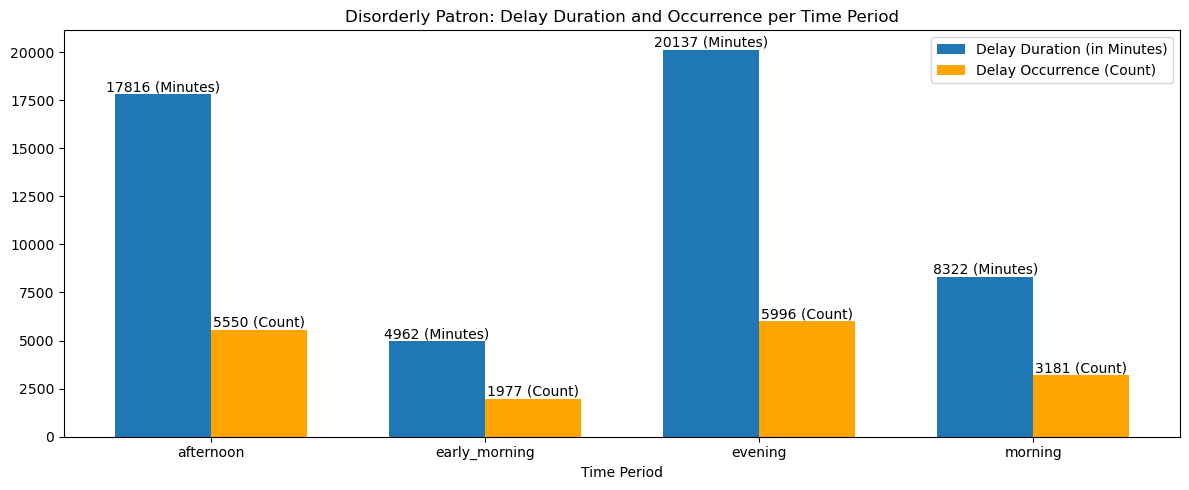

In [23]:
create_bar_chart(delay_cause = Disorderly_Patron,
                 title = 'Disorderly Patron: Delay Duration and Occurrence per Time Period')

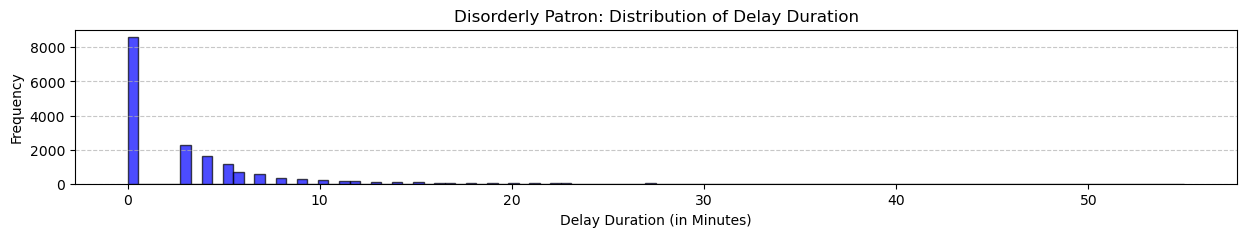

In [24]:
create_histogram(delay_cause = Disorderly_Patron,
                 title = 'Disorderly Patron: Distribution of Delay Duration')

### Unauthorized at Track Level

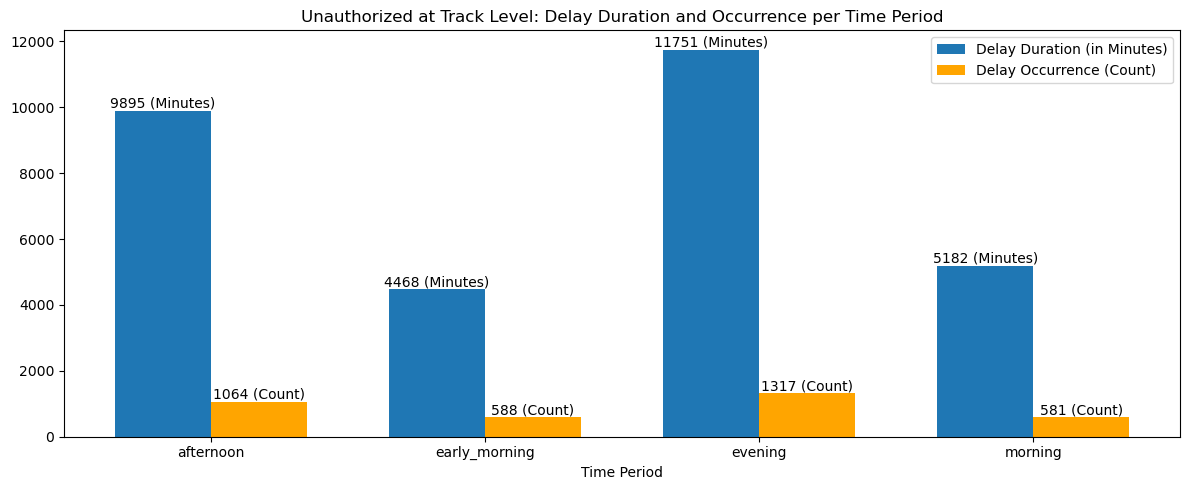

In [25]:
create_bar_chart(delay_cause = Unauthorized_at_Track_Level,
                 title = 'Unauthorized at Track Level: Delay Duration and Occurrence per Time Period')

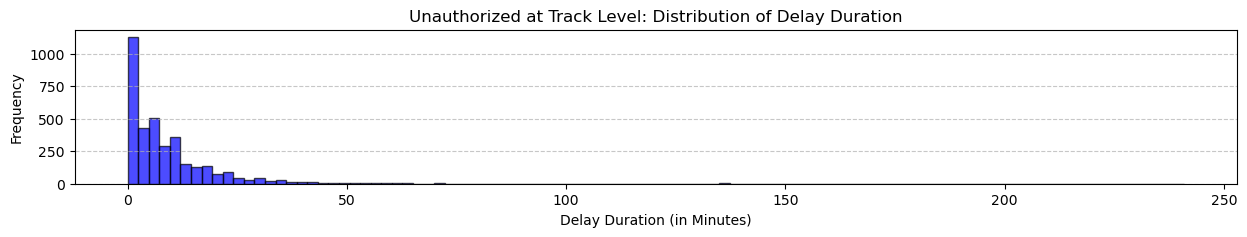

In [26]:
create_histogram(delay_cause = Unauthorized_at_Track_Level,
                 title = 'Unauthorized at Track Level: Distribution of Delay Duration')

### Passenger Other

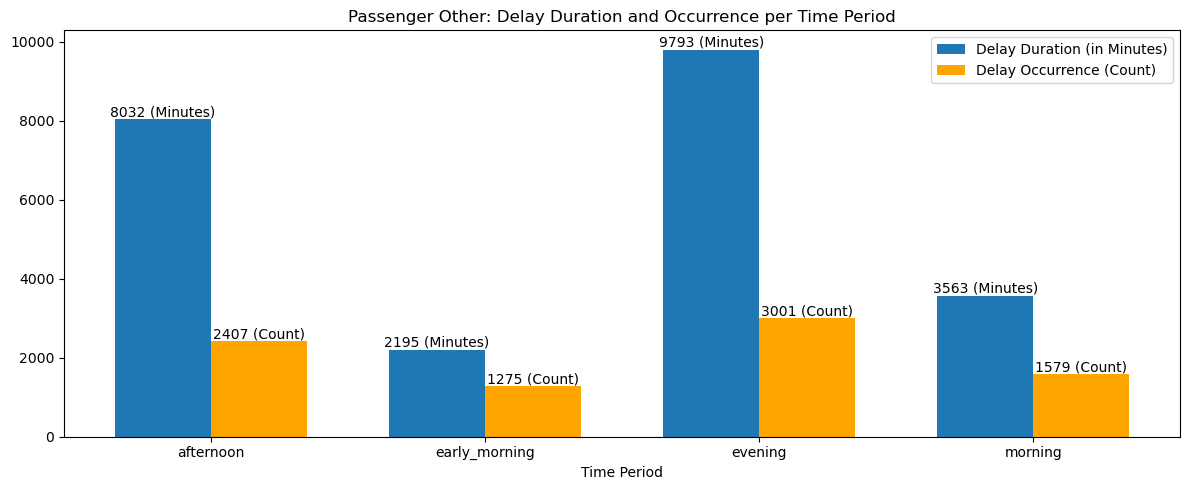

In [27]:
create_bar_chart(delay_cause = Passenger_Other,
                 title = 'Passenger Other: Delay Duration and Occurrence per Time Period')

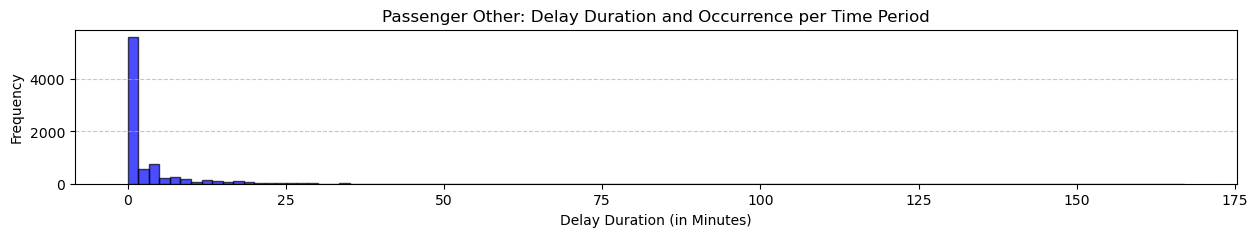

In [28]:
create_histogram(delay_cause = Passenger_Other,
                 title = 'Passenger Other: Delay Duration and Occurrence per Time Period')

### Passenger Assistance Alarm Activated - No Trouble Found

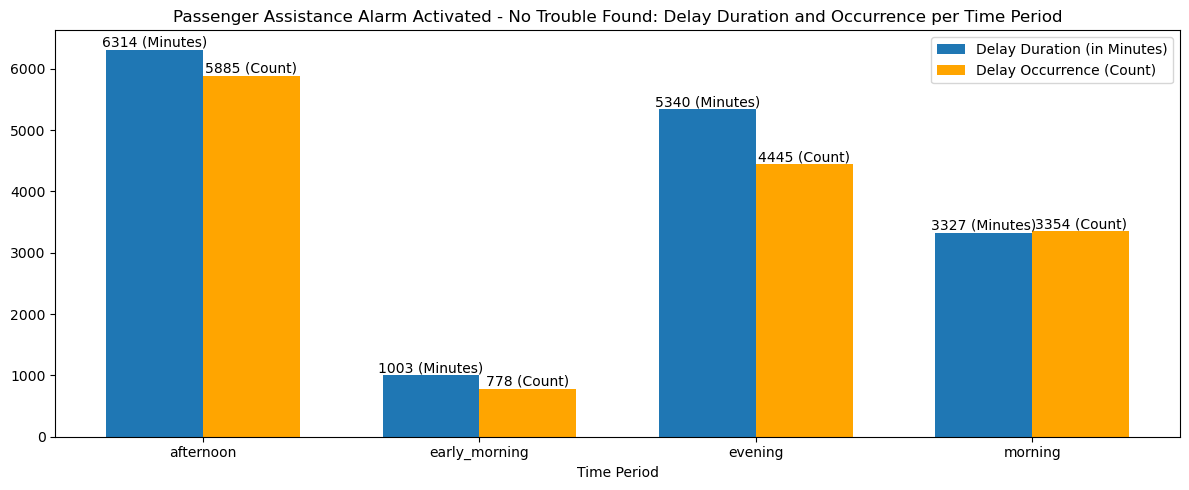

In [29]:
create_bar_chart(delay_cause = Passenger_Assistance_Alarm_Activated___No_Trouble_Found,
                 title = 'Passenger Assistance Alarm Activated - No Trouble Found: Delay Duration and Occurrence per Time Period')

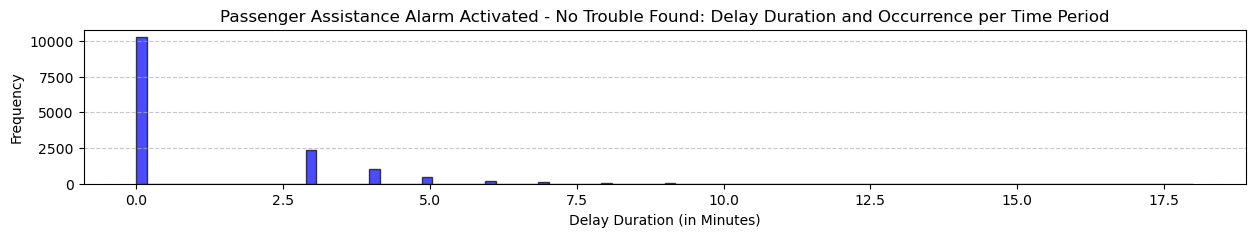

In [30]:
create_histogram(delay_cause = Passenger_Assistance_Alarm_Activated___No_Trouble_Found,
                 title = 'Passenger Assistance Alarm Activated - No Trouble Found: Delay Duration and Occurrence per Time Period')

### Priority One - Train in Contact with Person

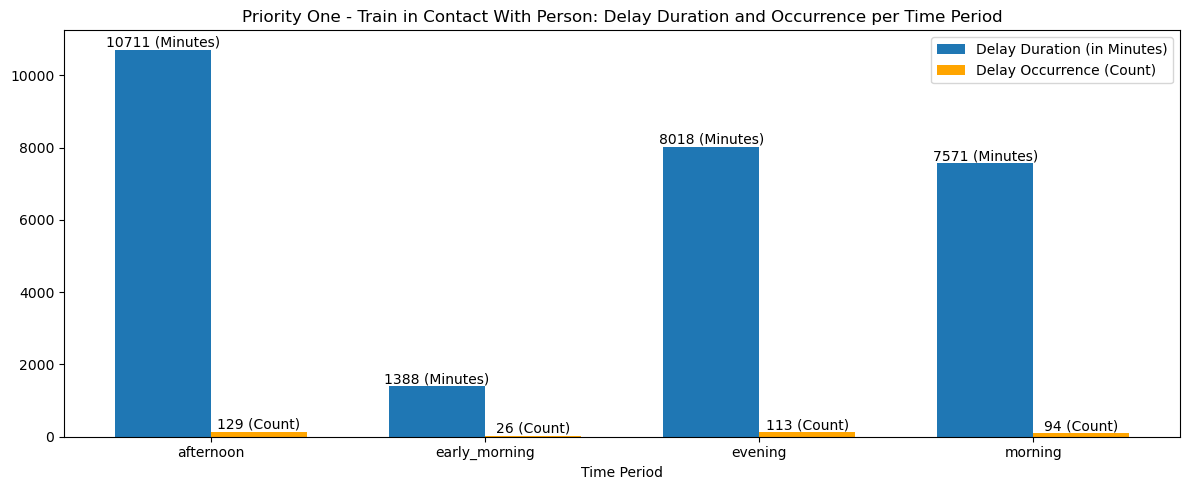

In [31]:
create_bar_chart(delay_cause = Priority_One___Train_in_Contact_With_Person,
                 title = 'Priority One - Train in Contact With Person: Delay Duration and Occurrence per Time Period')

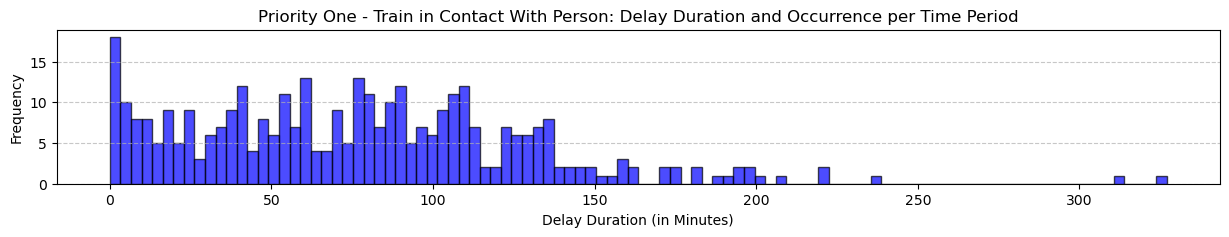

In [32]:
create_histogram(delay_cause = Priority_One___Train_in_Contact_With_Person,
                 title = 'Priority One - Train in Contact With Person: Delay Duration and Occurrence per Time Period')

### Findings: Passenger Related Category

The duration of all delay causes under Passenger Related category have gotten worse over time.

1. Disorderly Patrons have been the number 1 cause of the increasing delay durations of the TTC, taking into consideration all other delay causes under other delay categories.
- Disorderly Patrons are delays caused by commuters misbehaving. This may include fighting or any other behavior that disturbs other patrons while on the train. 
- This was classified as a Category 4 Risk (Critical Risk, or High-Likelihood High-Severity delays).
- The worsening delay duration of this particular cause has been found to be strongly statistically significant and not due to random chance.
- This often occurred during the evening (18:00 to 23:59), followed by the afternoon (12:00 to 17:59). Likewise, longer delay durations were found in the evenings followed by the afternoon.
- Average delay duration was 3.067349 minutes.

2. Unauthorized at Track Level was second
- Unauthorized at Track Level are delays caused by non-authorized people going down the track.
- This was classified as a Category 3 Risk (Black Swans, or Low-Likelihood High-Severity delays).
- The worsening delay duration of this particular cause has been found to be strongly statistically significant and not due to random chance.
- This often occurred during the evening (18:00 to 23:59), followed by the afternoon (12:00 to 17:59). Likewise, longer delay durations were found in the evenings followed by the afternoon.
- Average delay duration was 8.815775 minutes.

3. Passenger Other was third
- Passenger Other are unidentified delays and serve as a catch-all for passenger-related delays faced by the TTC
- This was classified as a Category 3 Risk (Black Swans, or Low-Likelihood High-Severity delays).
- The worsening delay duration of this particular cause has been found to be strongly statistically significant and not due to random chance.
- This often occurred during the evening (18:00 to 23:59), followed by the afternoon (12:00 to 17:59). Likewise, longer delay durations were found in the evenings followed by the afternoon.
- Average delay duration was 2.854394 minutes.

4. Passenger Assistance Alarm Activated - No Trouble Found was fourth
- Passenger Assistance Alarm Activated - No Trouble Found are delays caused by commuters triggering the request-for-assistance alarm inside train cabins. However, after TTC's response to the trigger, no trouble was found. The non-existence of an actual emergency might be due to pranks being played.
- This was classified as a Category 2 Risk (Frequent Nuisance, or High-Likelihood Low-Severity delays).
- The worsening delay duration of this particular cause has been found to be strongly statistically significant and not due to random chance.
- This often occurred during the afternoon (12:00 to 17:59), followed by the evening (18:00 to 23:59). Likewise, longer delay durations were found in the afternoon followed by the evening.
- Average delay duration was 1.105241 minutes.

5. Priority One - Train in Contact With Person
- Priority One - Train in Contact With Person are delays caused by the train coming into contact with anyone.
- This was classified as a Category 3 Risk (Black Swans, or Low-Likelihood High-Severity delays).
- The worsening delay duration of this particular cause has been found to be strongly statistically significant and not due to random chance.
- This often occurred during the afternoon (12:00 to 17:59), followed by the evening (18:00 to 23:59). Likewise, longer delay durations were found in the afternoon followed by the evening.
- Average delay duration was 76.486188 minutes.

## Equipment Related Category

In [33]:
grouped_category_monthly(delay_category = Equipment_Related)

,delay_cause,datetime,total_occurrence,delay_duration,average_delay,3-Month MA
0,ATC Project,2017-10-01,91,78,0.857143,NaN
1,ATC Project,2017-11-01,47,55,1.170213,NaN
2,ATC Project,2017-12-01,29,158,5.448276,97.000000
3,ATC Project,2018-01-01,25,208,8.320000,140.333333
4,ATC Project,2018-02-01,20,124,6.200000,163.333333
...,...,...,...,...,...,...
4583,Yard/Carhouse Related Problems,2024-05-01,3,13,4.333333,14.333333
4584,Yard/Carhouse Related Problems,2024-06-01,1,4,4.000000,11.666667
4585,Yard/Carhouse Related Problems,2024-07-01,4,8,2.000000,8.333333
4586,Yard/Carhouse Related Problems,2024-08-01,1,5,5.000000,5.666667


In [34]:
grouped_cause_category(delay_category = Equipment_Related)

,delay_cause,total_occurrence,delay_duration,average_delay
0,ATC Project,3302,15434,4.674137
1,ATC RC&S Equipment,124,644,5.193548
2,ATC Signals Other,54,132,2.444444
3,Air Conditioning,361,1518,4.204986
4,Alternating Current,59,306,5.186441
...,...,...,...,...
68,Wind Shield,3,19,6.333333
69,Work Vehicle,153,1993,13.026144
70,Work Zone Problems - Signals,105,562,5.352381
71,Work Zone Problems - Track,581,6020,10.361446


### Linear Regression on Delay Causes under Equipment Related Category

Some delay causes with strong significance (i.e. p-value less than 0.01) showed negative slopes, indicating an improvement in delay durations over time.

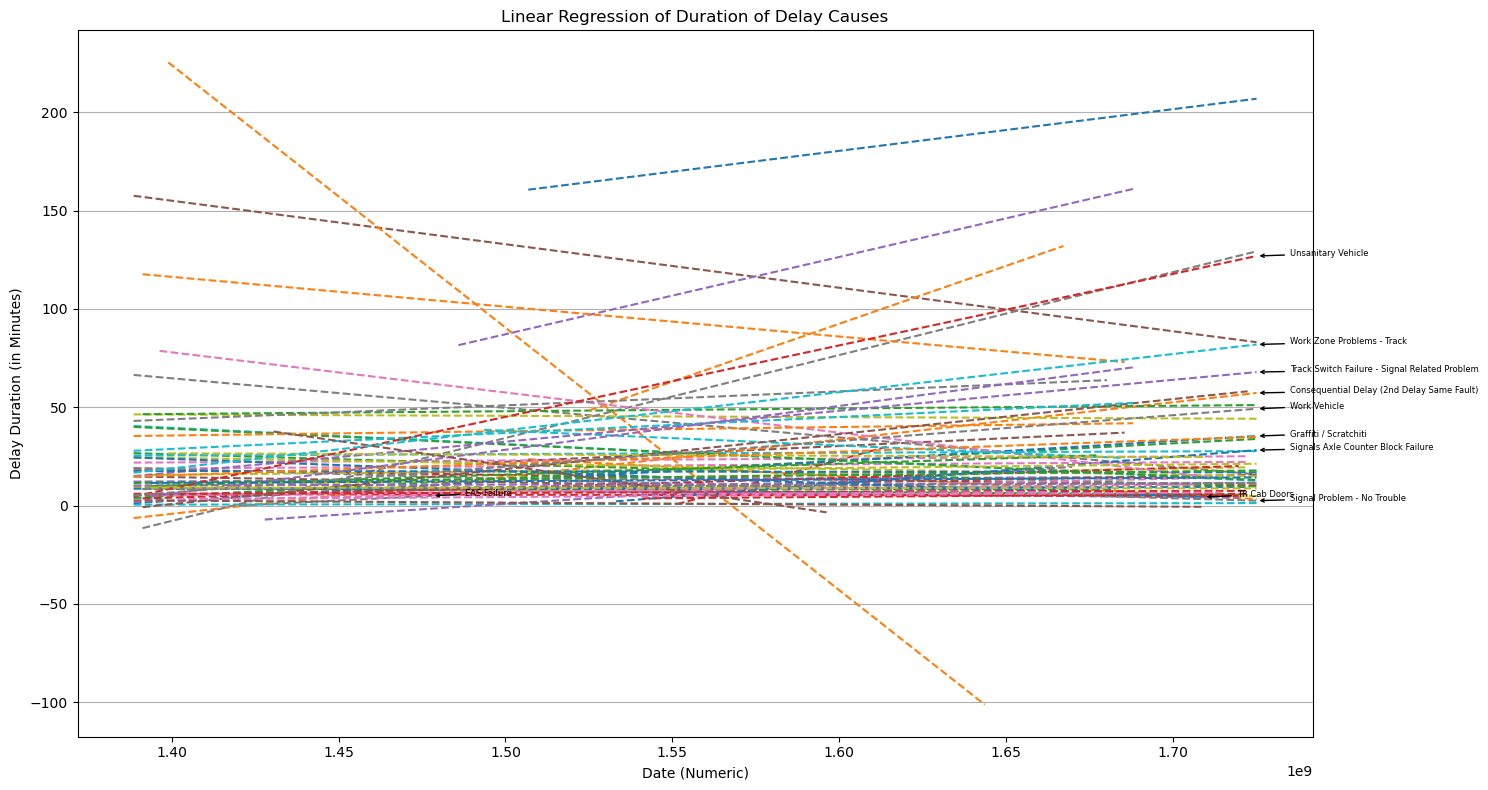

In [35]:
linear_regression_plot(delay_category = Equipment_Related)

In [36]:
linear_regression_table(delay_category = Equipment_Related)

,delay_cause,slope,intercept,r-value,p-value,std_err,pval < 0.05,pval < 0.01
63,Unsanitary Vehicle,3.633402e-07,-499.915436,0.706133,9.064581e-21,3.233007e-08,Y,Y
69,Work Zone Problems - Track,1.937628e-07,-252.364832,0.387689,1.215311e-05,4.241100e-08,Y,Y
11,Consequential Delay (2nd Delay Same Fault),1.889889e-07,-268.779241,0.262500,4.779886e-03,6.564384e-08,Y,Y
54,Track Switch Failure - Signal Related Problem,1.571086e-07,-203.169549,0.365795,5.817392e-05,3.760375e-08,Y,Y
40,Signals Axle Counter Block Failure,1.355882e-07,-205.730394,0.451012,8.952888e-04,3.833122e-08,Y,Y
67,Work Vehicle,1.307768e-07,-176.389423,0.383495,1.143251e-03,3.847611e-08,Y,Y
20,Graffiti / Scratchiti,1.012790e-07,-139.374542,0.558215,6.132228e-10,1.483263e-08,Y,Y
17,EAS Failure,8.637369e-08,-122.656716,1.000000,0.000000e+00,0.000000e+00,Y,Y
37,Signal Problem - No Trouble,-4.943146e-08,87.752594,-0.389551,1.003904e-05,1.071342e-08,Y,Y
50,TR Cab Doors,-6.249959e-08,111.208525,-0.459724,8.078823e-07,1.189610e-08,Y,Y


<Figure size 1500x800 with 0 Axes>

### Unsanitary Vehicle

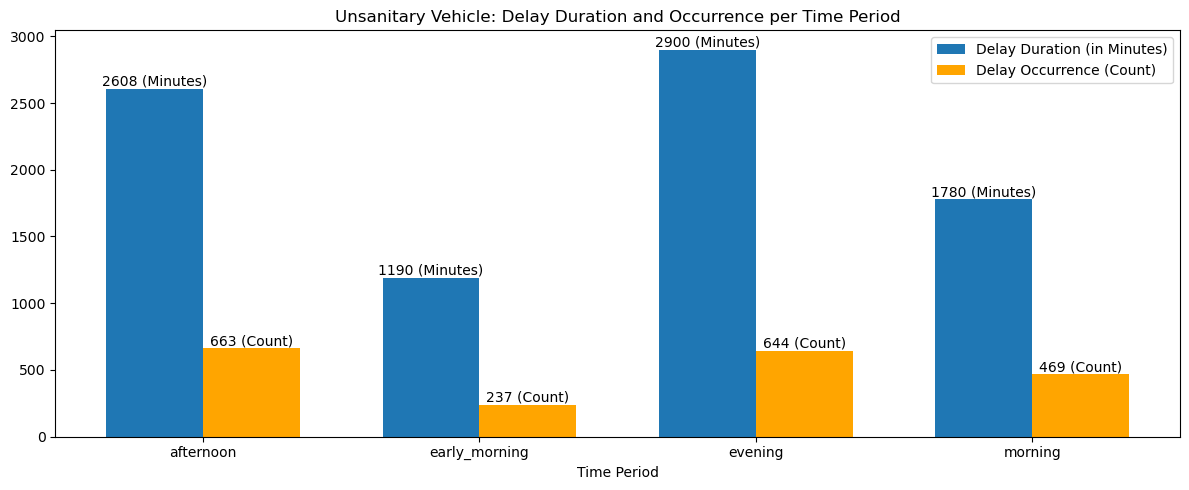

In [37]:
create_bar_chart(delay_cause = Unsanitary_Vehicle,
                 title = 'Unsanitary Vehicle: Delay Duration and Occurrence per Time Period')

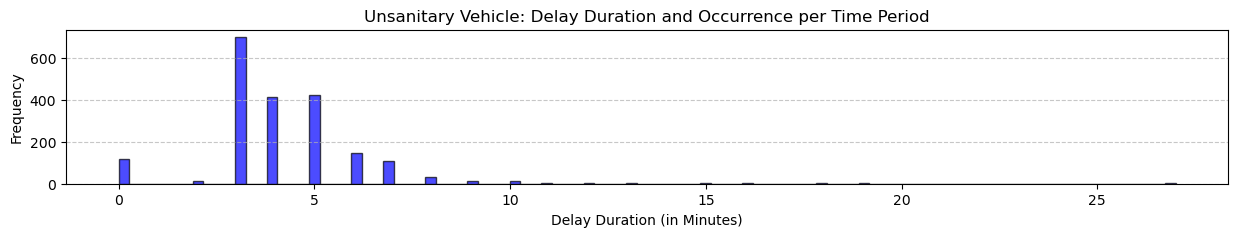

In [38]:
create_histogram(delay_cause = Unsanitary_Vehicle,
                 title = 'Unsanitary Vehicle: Delay Duration and Occurrence per Time Period')

### Work Zone Problems - Track

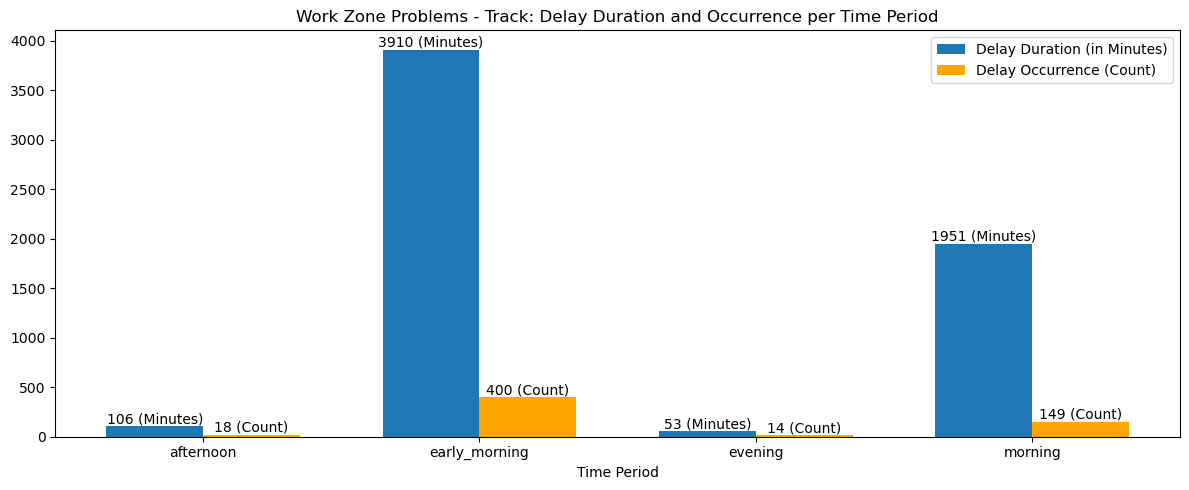

In [39]:
create_bar_chart(delay_cause = Work_Zone_Problems___Track,
                 title = 'Work Zone Problems - Track: Delay Duration and Occurrence per Time Period')

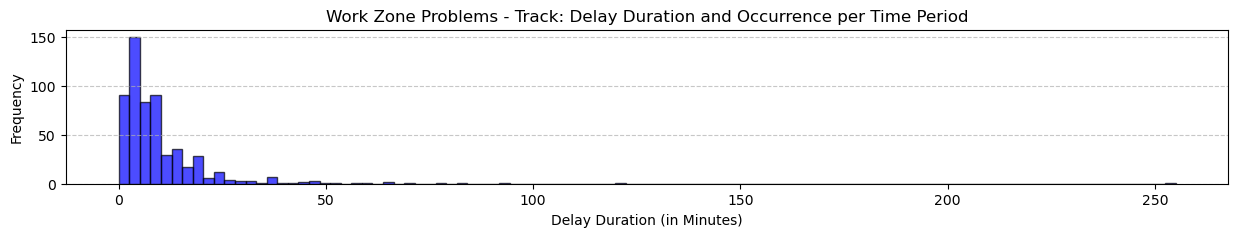

In [40]:
create_histogram(delay_cause = Work_Zone_Problems___Track,
                 title = 'Work Zone Problems - Track: Delay Duration and Occurrence per Time Period')

### Consequential Delay (2nd Delay Same Fault)	

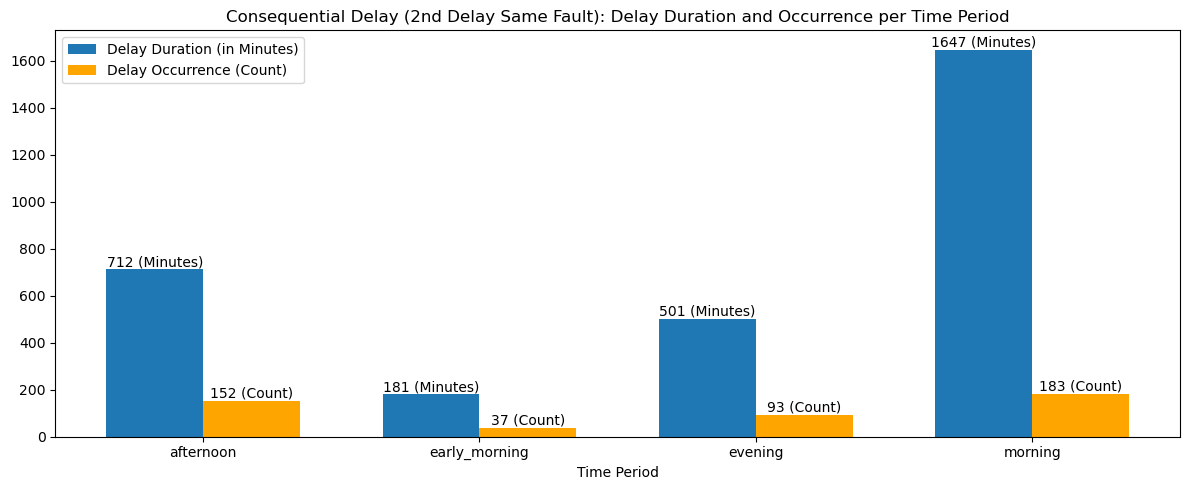

In [41]:
create_bar_chart(delay_cause = Consequential_Delay__2nd_Delay_Same_Fault_,
                 title = 'Consequential Delay (2nd Delay Same Fault): Delay Duration and Occurrence per Time Period')

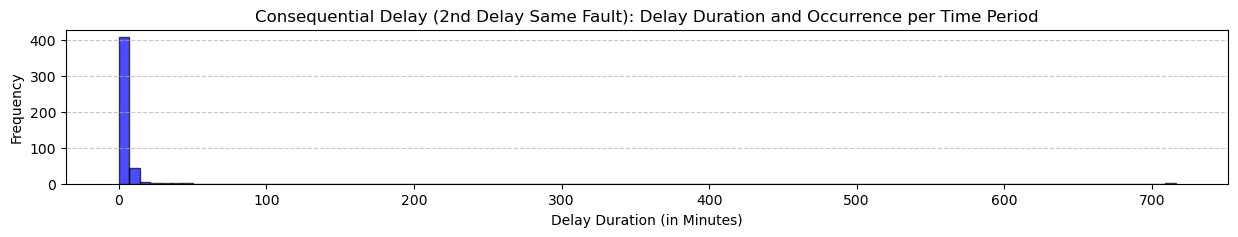

In [42]:
create_histogram(delay_cause = Consequential_Delay__2nd_Delay_Same_Fault_,
                 title = 'Consequential Delay (2nd Delay Same Fault): Delay Duration and Occurrence per Time Period')

### Track Switch Failure - Signal Related Problem

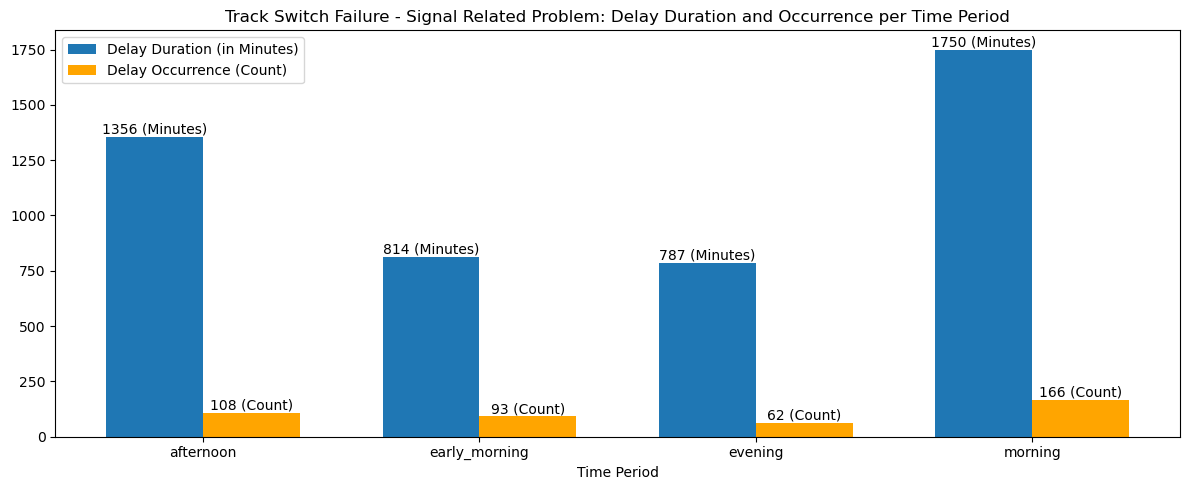

In [43]:
create_bar_chart(delay_cause = Track_Switch_Failure___Signal_Related_Problem,
                 title = 'Track Switch Failure - Signal Related Problem: Delay Duration and Occurrence per Time Period')

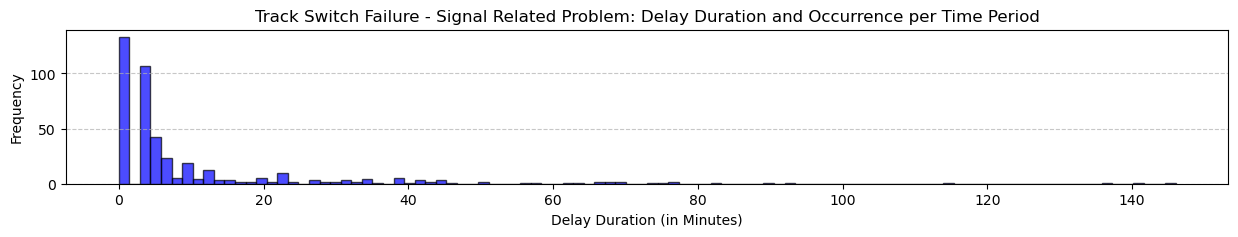

In [44]:
create_histogram(delay_cause = Track_Switch_Failure___Signal_Related_Problem,
                 title = 'Track Switch Failure - Signal Related Problem: Delay Duration and Occurrence per Time Period')

### Signals Axle Counter Block Failure	

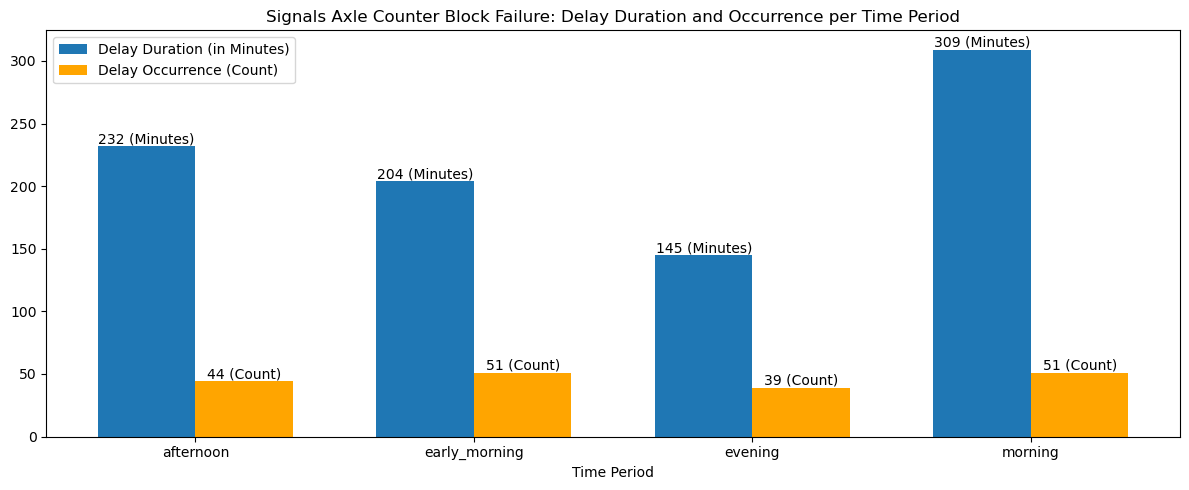

In [45]:
create_bar_chart(delay_cause = Signals_Axle_Counter_Block_Failure,
                 title = 'Signals Axle Counter Block Failure: Delay Duration and Occurrence per Time Period')

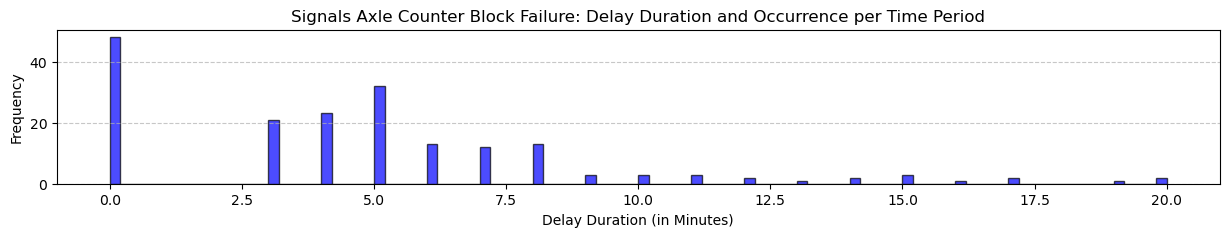

In [46]:
create_histogram(delay_cause = Signals_Axle_Counter_Block_Failure,
                 title = 'Signals Axle Counter Block Failure: Delay Duration and Occurrence per Time Period')

### Findings: Equipment Related Category

The duration of most delay causes under Equipment Related category have gotten marginally worse over time. However, the slopes of its delay causes were not as bad as those under Passenger Related category. 

1. Unsanitary Vehicle had the highest slope
- Unsanitary Vehicle are delays caused by dirty trains.
- This was classified as a Category 1 Risk (Unlikely Bother, or Low-Likelihood Low-Severity delays).
- The worsening delay duration of this particular cause has been found to be strongly statistically significant and not due to random chance.
- This often occurred during the afternoon (12:00 to 17:59), followed by the evening (18:00 to 23:59). However, total delay duration was summed longer in the evening than in the afternoon. This may be due to speedier clean-up time during the afternoon, when there are more TTC personnel.
- Average delay duration was 4.211624 minutes.

2. Work-Zone Problems - Tracks was second
- Work-Zone Problems - Tracks are delays caused by construction or maintenance work along the tracks.
- This was classified as a Category 1 Risk (Unlikely Bother, or Low-Likelihood Low-Severity delays).
- The worsening delay duration of this particular cause has been found to be strongly statistically significant and not due to random chance.
- This often occurred during the early morning (00:00 to 5:59), followed by the morning (6:00 to 11:59). Likewise, longer delay durations were found in the early morning followed by the morning. This may be because of TTC's scheduling of construction/maintenance activities during the early hours of the day.
- Average delay duration was 10.361446 minutes.

3. Consequential Delay (2nd Delay Same Fault) - was third
- This delay cause is vague because it is related to another preceding delay cause. TTC does not label the preceding cause of delay, so we have no means of knowing what the actual cause is.

4. Track Switch Failure - Signal Related Problem was fourth
- Track Switch Failure - Signal Related Problem are delays caused by signal problems related to track switches.
- This was classified as a Category 1 Risk (Unlikely Bother, or Low-Likelihood Low-Severity delays).
- The worsening delay duration of this particular cause has been found to be strongly statistically significant and not due to random chance.
- This often occurred during the morning (6:00 to 11:59), followed by the afternoon (12:00 to 17:59). Likewise, longer delay durations were found in the morning followed by the afternoon.
- Average delay duration was 19.540984 minutes.

5. Signals Axle Counter Block Failure
- Signals Axle Counter Block Failure refers to a malfunction in the axle counter system used in railway signaling, where the system fails to accurately detect the number of axles passing through a specific track section, essentially meaning it can't reliably determine if a train is present in that section, potentially leading to safety issues and causing disruption to train operations. This often happens due to power supply issues or faulty sensors within the axle counter system, requiring manual intervention to reset and verify the track status before allowing trains to proceed. 
- This was classified as a Category 1 Risk (Unlikely Bother, or Low-Likelihood Low-Severity delays).
- The worsening delay duration of this particular cause has been found to be strongly statistically significant and not due to random chance.
- This often occurred during the early morning (00:00 to 5:59) and morning (6:00 to 11:59), followed by the afternoon (12:00 to 17:59). Longer delay durations were found in the morning followed by the afternoon.
- Average delay duration was 4.810811 minutes.

## Personnel Related Category

In [47]:
grouped_category_monthly(delay_category = Personnel_Related)

,delay_cause,datetime,total_occurrence,delay_duration,average_delay,3-Month MA
0,ATC Operator Related,2017-10-01,2,7,3.500000,NaN
1,ATC Operator Related,2017-11-01,2,0,0.000000,NaN
2,ATC Operator Related,2017-12-01,7,55,7.857143,20.666667
3,ATC Operator Related,2018-01-01,4,36,9.000000,30.333333
4,ATC Operator Related,2018-02-01,11,64,5.818182,51.666667
...,...,...,...,...,...,...
2353,Work Refusal,2024-05-01,5,12,2.400000,4.000000
2354,Work Refusal,2024-06-01,3,15,5.000000,9.000000
2355,Work Refusal,2024-07-01,4,6,1.500000,11.000000
2356,Work Refusal,2024-08-01,3,29,9.666667,16.666667


In [48]:
grouped_cause_category(delay_category = Personnel_Related)

,delay_cause,total_occurrence,delay_duration,average_delay
0,ATC Operator Related,342,1467,4.289474
1,Crew Unable to Maintain Schedule,387,2050,5.297158
2,Divisional Clerk Related,339,1524,4.495575
3,ECD / Line Mechanic Related Prob.,52,272,5.230769
4,Injured Employee,939,568,0.604899
5,Labour Dispute - Subway,2,0,0.000000
6,Misc. Transportation Other - Employee Non-Char...,2807,9138,3.255433
7,No Operator Immediately Available,2032,7862,3.869094
8,No Operator Immediately Available - Not E.S.A....,2249,8252,3.669186
9,OPTO (COMMS) Train Door Monitoring,3935,13130,3.336722


### Linear Regression on Delay Causes under Personnel Related Category

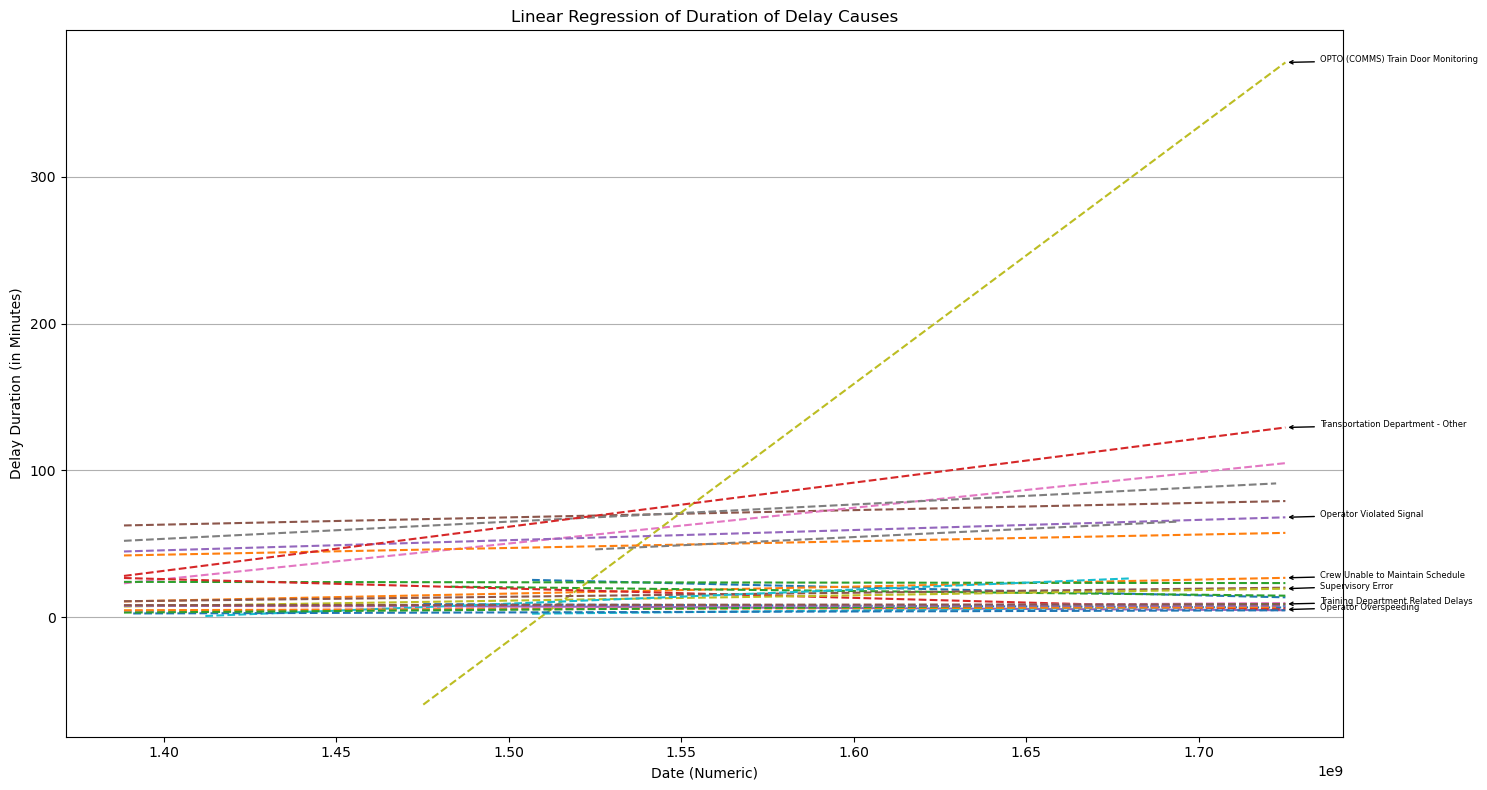

In [49]:
linear_regression_plot(delay_category = Personnel_Related)

In [50]:
linear_regression_table(delay_category = Personnel_Related)

,delay_cause,slope,intercept,r-value,p-value,std_err,pval < 0.05,pval < 0.01
8,OPTO (COMMS) Train Door Monitoring,1.751100e-06,-2642.904782,0.776071,4.598326e-16,1.676981e-07,Y,Y
23,Transportation Department - Other,3.005088e-07,-389.132524,0.684158,3.998458e-19,2.842658e-08,Y,Y
14,Operator Violated Signal,6.910613e-08,-51.155848,0.247311,4.719164e-03,2.402517e-08,Y,Y
1,Crew Unable to Maintain Schedule,4.776989e-08,-55.565169,0.308260,1.305498e-03,1.445567e-08,Y,Y
18,Supervisory Error,3.598849e-08,-42.659735,0.299572,1.634478e-03,1.113247e-08,Y,Y
22,Training Department Related Delays,1.734960e-08,-20.918655,0.270318,3.480524e-03,5.812979e-09,Y,Y
13,Operator Overspeeding,-6.396196e-08,115.535174,-0.447331,1.068068e-07,1.134770e-08,Y,Y


<Figure size 1500x800 with 0 Axes>

### OPTO (COMMS) Train Door Monitoring

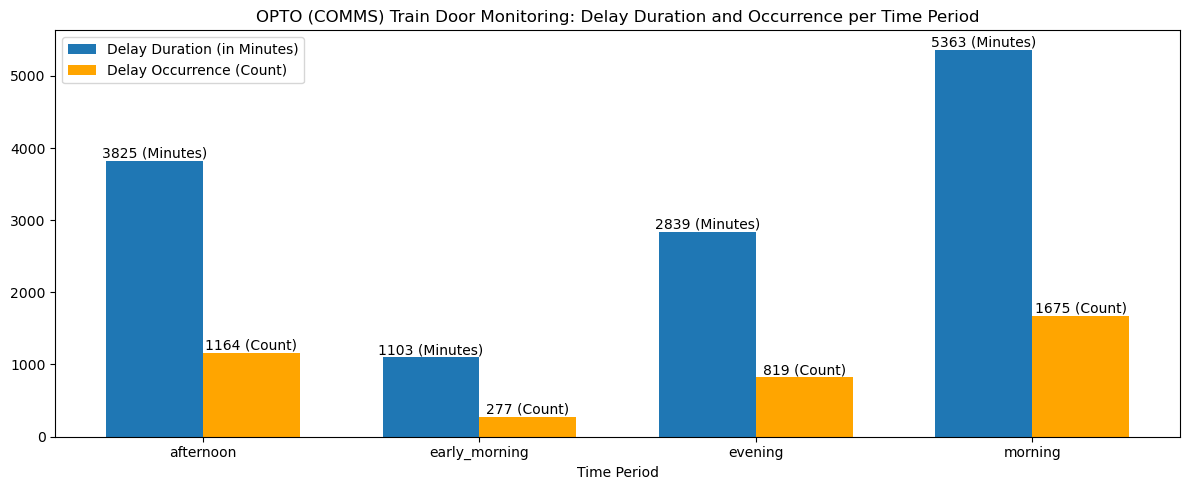

In [51]:
create_bar_chart(delay_cause = OPTO__COMMS__Train_Door_Monitoring,
                 title = 'OPTO (COMMS) Train Door Monitoring: Delay Duration and Occurrence per Time Period')

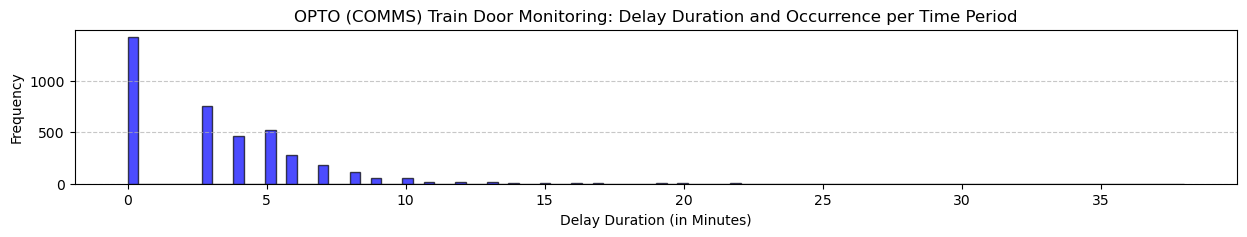

In [52]:
create_histogram(delay_cause = OPTO__COMMS__Train_Door_Monitoring,
                 title = 'OPTO (COMMS) Train Door Monitoring: Delay Duration and Occurrence per Time Period')

### Transportation Department - Other

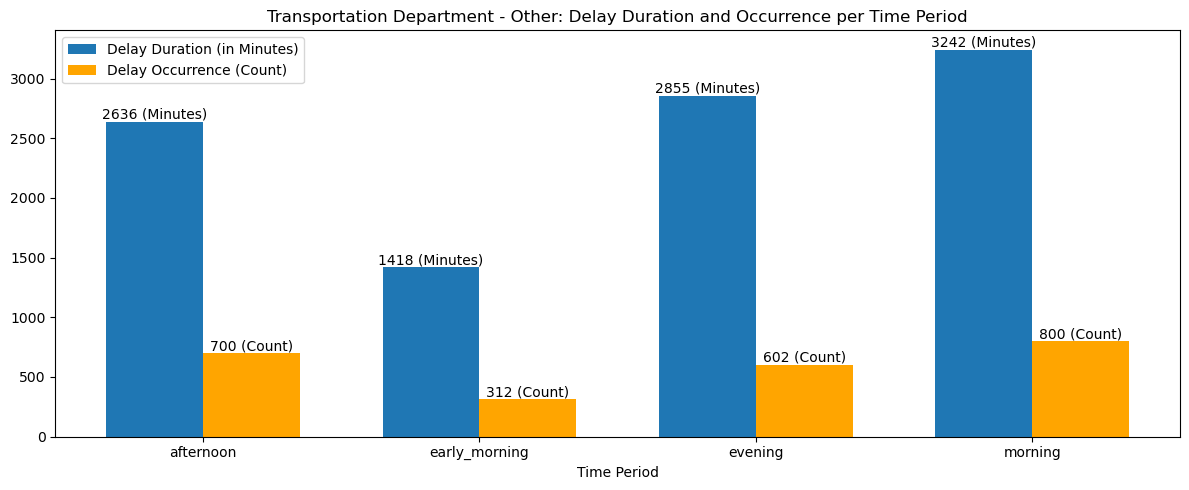

In [53]:
create_bar_chart(delay_cause = Transportation_Department___Other,
                 title = 'Transportation Department - Other: Delay Duration and Occurrence per Time Period')

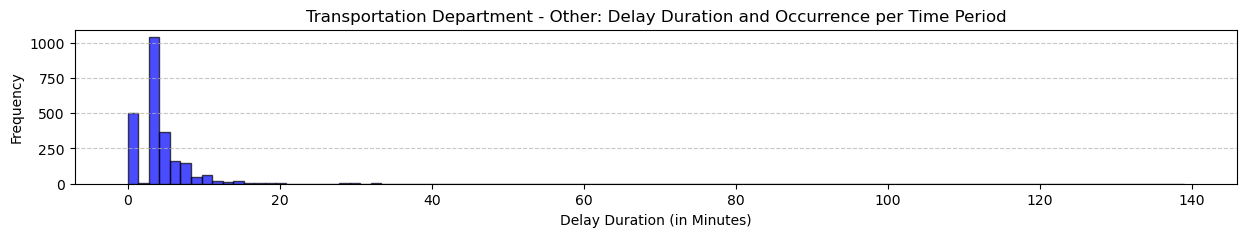

In [54]:
create_histogram(delay_cause = Transportation_Department___Other,
                 title = 'Transportation Department - Other: Delay Duration and Occurrence per Time Period')

### Operator Violated Signal

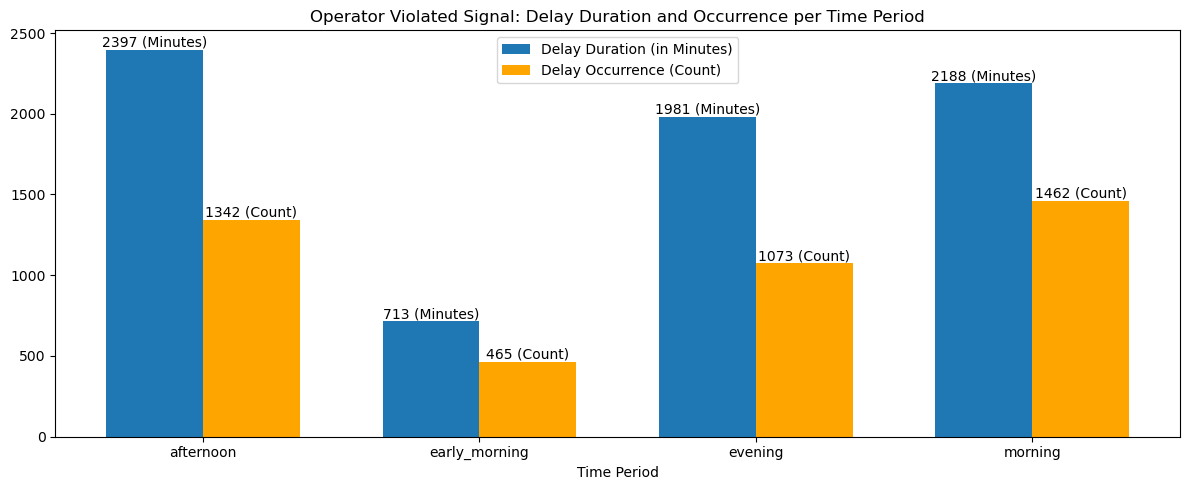

In [55]:
create_bar_chart(delay_cause = Operator_Violated_Signal,
                 title = 'Operator Violated Signal: Delay Duration and Occurrence per Time Period')

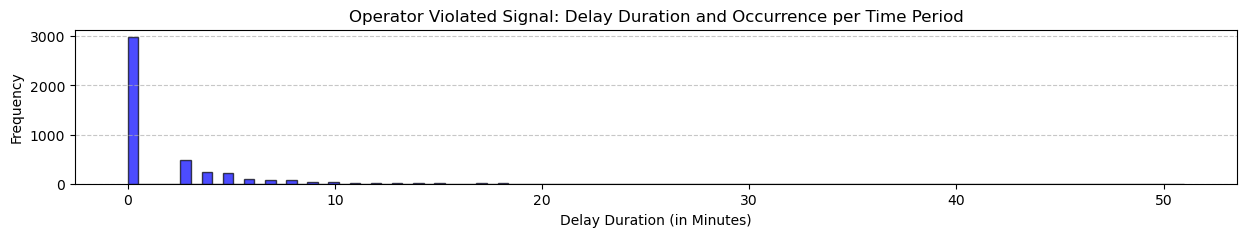

In [56]:
create_histogram(delay_cause = Operator_Violated_Signal,
                 title = 'Operator Violated Signal: Delay Duration and Occurrence per Time Period')

### Crew Unable to Maintain Schedule

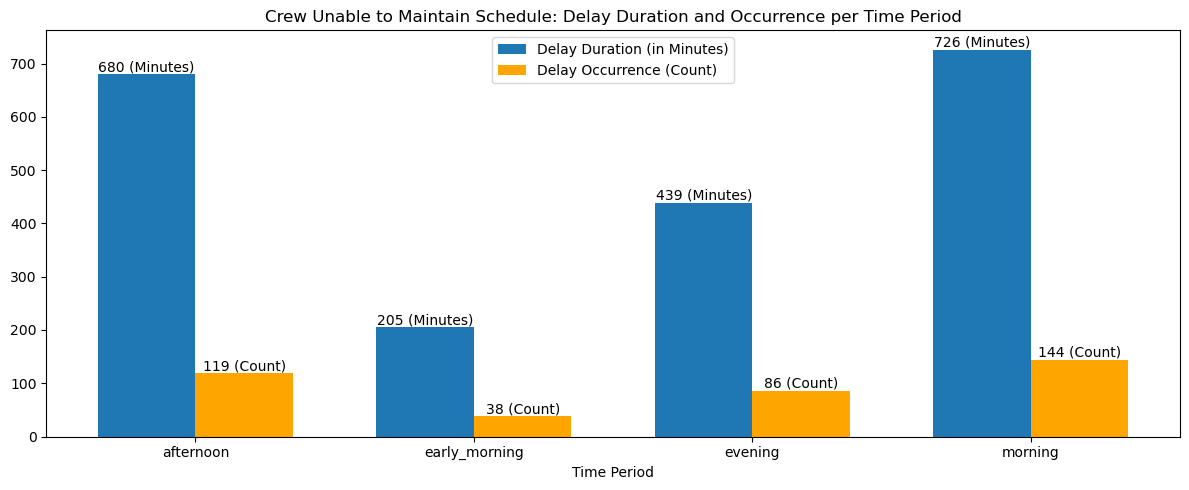

In [57]:
create_bar_chart(delay_cause = Crew_Unable_to_Maintain_Schedule,
                 title = 'Crew Unable to Maintain Schedule: Delay Duration and Occurrence per Time Period')

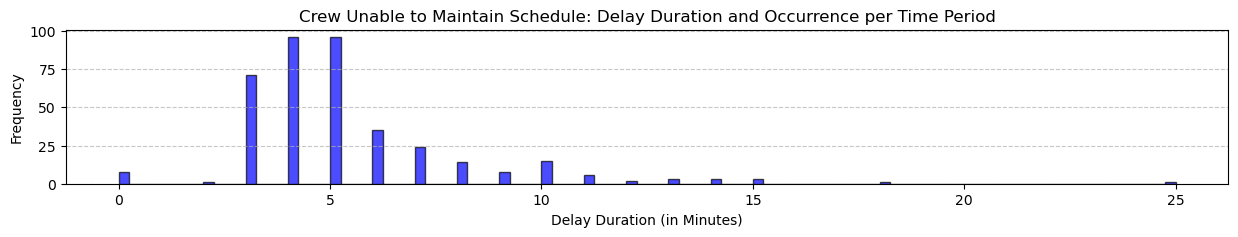

In [58]:
create_histogram(delay_cause = Crew_Unable_to_Maintain_Schedule,
                 title = 'Crew Unable to Maintain Schedule: Delay Duration and Occurrence per Time Period')

### Supervisory Error	

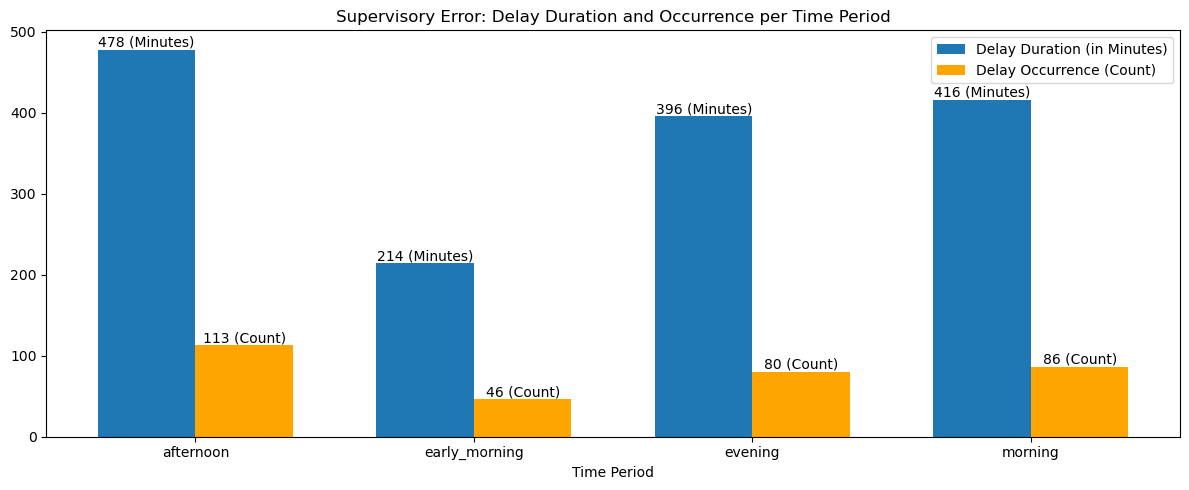

In [59]:
create_bar_chart(delay_cause = Supervisory_Error,
                 title = 'Supervisory Error: Delay Duration and Occurrence per Time Period')

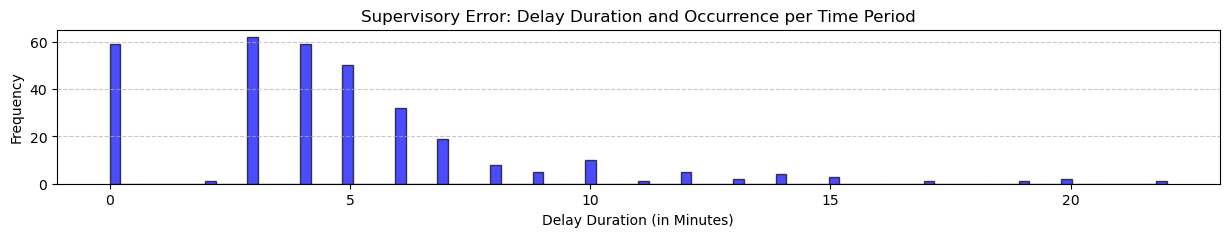

In [60]:
create_histogram(delay_cause = Supervisory_Error,
                 title = 'Supervisory Error: Delay Duration and Occurrence per Time Period')

### Findings: Personnel Related Category

Like Equipment Related category, Personnel Related category delays were not as bad as those under Passenger Related. Noteworthy, however, is OPTO (Comms) Train Door Monitoring, which had the second highest slope after Disorderly Patron.

1. OPTO (Comms) Train Door Monitoring had the highest slope in this category
- "OPTO" in the context of train door monitoring stands for "One-Person Operation" which refers to a system where a single train operator can manage the entire train, including door operations, without the need for a separate conductor, and the "Train Door Monitoring" part indicates a system that uses cameras or sensors to continuously monitor the status of the train doors to ensure safe passenger entry and exit, all managed by the single operator. 
- This was classified as a Category 1 Risk (Unlikely Bother, or Low-Likelihood Low-Severity delays).
- The worsening delay duration of this particular cause has been found to be strongly statistically significant and not due to random chance.
- This often occurred during the morning (6:00 to 11:59), followed by the afternoon (12:00 to 17:59). Likewise, total delay duration was longest in the morning followed by the afternoon.
- Average delay duration was 3.336722 minutes.

2. Transportation Department - Other came second
- This delay cause is vague in terms of its label.
- This was classified as a Category 1 Risk (Unlikely Bother, or Low-Likelihood Low-Severity delays).
- The worsening delay duration of this particular cause has been found to be strongly statistically significant and not due to random chance.
- This often occurred during the morning (6:00 to 11:59), followed by the afternoon (12:00 to 17:59). Likewise, total delay duration was longest in the morning.
- Average delay duration was 4.205054 minutes.

3. Operator Violated Signal was third
- The TTC has a mechanism in place that signals an operator whether he/she should proceed to a section of a track. For instance, TTC will tell the operator to not proceed if another train (or, in some cases, debris) is currently occupying (or blocking) the next track section. If an operator violates this signal, a brake mechanism engages, which causes the train to stop.
- This was classified as a Category 1 Risk (Unlikely Bother, or Low-Likelihood Low-Severity delays).
- The worsening delay duration of this particular cause has been found to be strongly statistically significant and not due to random chance.
- This often occurred during the afternoon (12:00 to 17:59), followed by the morning (6:00 to 11:59). Likewise, total delay duration was longest in the morning.
- Average delay duration was 1.676416 minutes.

4. Crew Unable to Maintain Schedule was fourth
- This was classified as a Category 1 Risk (Unlikely Bother, or Low-Likelihood Low-Severity delays).
- The worsening delay duration of this particular cause has been found to be strongly statistically significant and not due to random chance.
- This often occurred during the morning (6:00 to 11:59), followed by the afternoon (12:00 to 17:59). Likewise, total delay duration was longest in the morning.
- Average delay duration was 5.297158 minutes.

5. Supervisory Error was fifth
- This was classified as a Category 1 Risk (Unlikely Bother, or Low-Likelihood Low-Severity delays).
- The worsening delay duration of this particular cause has been found to be strongly statistically significant and not due to random chance.
- This often occurred during the afternoon (12:00 to 17:59), followed by the morning (6:00 to 11:59). Likewise, total delay duration was longest in the afternoon.
- Average delay duration was 4.627692 minutes.

# **EXPLORATORY DATA ANALYSIS - STATIONS**

## Data Extraction and Cleaning

Here, we'll conduct EDA on the stations and check for any patterns or trends. We'll be importing map data from an arcgis database accessible through a url, so we can plot our data in a map that will look like the TTC subway. We can also do an EDA using the typical charts such as bar or line (as we did above), but I want to make things visually interesting for the spatial data we have for this part of our EDA.

In [61]:
url = "https://gis.toronto.ca/arcgis/rest/services/cot_geospatial7/FeatureServer/8/query?where=1%3D1&outFields=*&outSR=4326&f=geojson"
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad responses
geojson_data = json.loads(response.text)

# Convert the GeoJSON data to a GeoDataFrame
ttc_map = gpd.GeoDataFrame.from_features(geojson_data["features"])
ttc_map

,geometry,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS_FULL,POSTAL_CODE,MUNICIPALITY,CITY,PLACE_NAME,GENERAL_USE_CODE,...,PT_KISS_RIDE,PT_ESCALATOR,PT_ELEVATOR,PT_TRANSF_REQ,PT_PUB_WASH,PT_PHONE,PT_OTHER_TRAN,PT_WEBSITE,PT_EXTRA1,PT_EXTRA2
0,POINT (-79.39835 43.70534),11272589,2190,Yonge St,2190 Yonge St,M4S 2B8,former Toronto,Toronto,None,115001,...,No,"Train Platform to Mezzanine, Bus Platform and ...",Yes,"97,A,B,C,D Only",Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Eglinton/sta...,None,None
1,POINT (-79.39712 43.69785),7273830,1900,Yonge St,1900 Yonge St,M4S 1Z2,former Toronto,Toronto,None,115001,...,No,"Train Platform to Mezzanine, Bus Platform and ...",Yes,No,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Davisville/s...,None,None
2,POINT (-79.39298 43.68811),14076438,15,St Clair Ave E,15 St Clair Ave E,M4T 1L8,former Toronto,Toronto,None,115001,...,No,"Train Platform to Mezzanine, Streetcar Platfor...",Yes,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/St_Clair/sta...,None,None
3,POINT (-79.39079 43.68229),8681089,16,Shaftesbury Ave,16 Shaftesbury Ave,None,former Toronto,Toronto,None,115001,...,No,No,No,Yes,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Summerhill/s...,None,None
4,POINT (-79.38875 43.67694),788874,7,Crescent Rd,7 Crescent Rd,None,former Toronto,Toronto,None,115001,...,No,No,No,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Rosedale/sta...,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,POINT (-79.41309 43.76901),14076455,5152,Yonge St,5152 Yonge St,None,North York,Toronto,None,115001,...,No,Train Platform to Mezzanine,No,"97,B,C Only",No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/North_York_C...,None,None
69,POINT (-79.41236 43.7617),13967653,20,Sheppard Ave W,20 Sheppard Ave W,M2N 7H9,North York,Toronto,None,115001,...,No,Train Platform to Mezzanine and Bus Platform,Yes,"97,B,C Only",Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Sheppard-Yon...,None,None
70,POINT (-79.40636 43.7449),12036646,4025,Yonge St,4025 Yonge St,M2P 2E3,North York,Toronto,None,115001,...,No,Train Platform to Bus Platform and Street,Yes,"97,B,C Only",No,(416) 393-4636,GO York Mills,http://www.ttc.ca/Subway/Stations/York_Mills/s...,None,None
71,POINT (-79.40193 43.72535),7762894,3101,Yonge St,3101 Yonge St,None,former Toronto,Toronto,George Milbrandt Parkette,115001,...,No,"Train Platform to Mezzanine, Bus Platform and ...",No,"97,A,B,C,D Only",No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Lawrence/sta...,None,None


Looking at the above extracted geographic data set from arcgis, we can see two (2) concerns:
1. There's no explicit column for the station name. We can, however, extract this from the 'PT_WEBSITE' column; and
2. Two (2) stations are missing from the data set: Vaughan Metropolitan Centre and Highway 407. We'll try to append these two to the data set above. The important features we need are 'geometry' (latitude and longitude) and the station name.

Let's work on extracting the station name first.

In [62]:
ttc_map['station_clean'] = ttc_map['PT_WEBSITE'].str.extract(r'http://www.ttc.ca/Subway/Stations/([^/]+)')
ttc_map['station_clean'] = ttc_map['station_clean'].str.replace('_', ' ')
ttc_map['station_clean'] = ttc_map['station_clean'].str.replace('St', 'St.')
ttc_map

,geometry,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS_FULL,POSTAL_CODE,MUNICIPALITY,CITY,PLACE_NAME,GENERAL_USE_CODE,...,PT_ESCALATOR,PT_ELEVATOR,PT_TRANSF_REQ,PT_PUB_WASH,PT_PHONE,PT_OTHER_TRAN,PT_WEBSITE,PT_EXTRA1,PT_EXTRA2,station_clean
0,POINT (-79.39835 43.70534),11272589,2190,Yonge St,2190 Yonge St,M4S 2B8,former Toronto,Toronto,None,115001,...,"Train Platform to Mezzanine, Bus Platform and ...",Yes,"97,A,B,C,D Only",Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Eglinton/sta...,None,None,Eglinton
1,POINT (-79.39712 43.69785),7273830,1900,Yonge St,1900 Yonge St,M4S 1Z2,former Toronto,Toronto,None,115001,...,"Train Platform to Mezzanine, Bus Platform and ...",Yes,No,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Davisville/s...,None,None,Davisville
2,POINT (-79.39298 43.68811),14076438,15,St Clair Ave E,15 St Clair Ave E,M4T 1L8,former Toronto,Toronto,None,115001,...,"Train Platform to Mezzanine, Streetcar Platfor...",Yes,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/St_Clair/sta...,None,None,St. Clair
3,POINT (-79.39079 43.68229),8681089,16,Shaftesbury Ave,16 Shaftesbury Ave,None,former Toronto,Toronto,None,115001,...,No,No,Yes,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Summerhill/s...,None,None,Summerhill
4,POINT (-79.38875 43.67694),788874,7,Crescent Rd,7 Crescent Rd,None,former Toronto,Toronto,None,115001,...,No,No,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Rosedale/sta...,None,None,Rosedale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,POINT (-79.41309 43.76901),14076455,5152,Yonge St,5152 Yonge St,None,North York,Toronto,None,115001,...,Train Platform to Mezzanine,No,"97,B,C Only",No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/North_York_C...,None,None,North York Centre
69,POINT (-79.41236 43.7617),13967653,20,Sheppard Ave W,20 Sheppard Ave W,M2N 7H9,North York,Toronto,None,115001,...,Train Platform to Mezzanine and Bus Platform,Yes,"97,B,C Only",Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Sheppard-Yon...,None,None,Sheppard-Yonge
70,POINT (-79.40636 43.7449),12036646,4025,Yonge St,4025 Yonge St,M2P 2E3,North York,Toronto,None,115001,...,Train Platform to Bus Platform and Street,Yes,"97,B,C Only",No,(416) 393-4636,GO York Mills,http://www.ttc.ca/Subway/Stations/York_Mills/s...,None,None,York Mills
71,POINT (-79.40193 43.72535),7762894,3101,Yonge St,3101 Yonge St,None,former Toronto,Toronto,George Milbrandt Parkette,115001,...,"Train Platform to Mezzanine, Bus Platform and ...",No,"97,A,B,C,D Only",No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Lawrence/sta...,None,None,Lawrence


Now that that's done, let's work on adding the rows for the two (2) missing stations.

In [63]:
new_rows = [{'geometry': 'POINT (-79.5275 43.794167)', 'station_clean': 'Vaughan Metropolitan Centre'},
            {'geometry': 'POINT (-79.523056 43.783333)', 'station_clean': 'Highway'}]

for row in new_rows:
    for col in ttc_map.columns:
        row.setdefault(col, np.nan)

# Append new rows
ttc_map = pd.concat([ttc_map, pd.DataFrame(new_rows)], ignore_index=True)
ttc_map

,geometry,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS_FULL,POSTAL_CODE,MUNICIPALITY,CITY,PLACE_NAME,GENERAL_USE_CODE,...,PT_ESCALATOR,PT_ELEVATOR,PT_TRANSF_REQ,PT_PUB_WASH,PT_PHONE,PT_OTHER_TRAN,PT_WEBSITE,PT_EXTRA1,PT_EXTRA2,station_clean
0,POINT (-79.398354474049 43.70533823171372),11272589.0,2190,Yonge St,2190 Yonge St,M4S 2B8,former Toronto,Toronto,None,115001.0,...,"Train Platform to Mezzanine, Bus Platform and ...",Yes,"97,A,B,C,D Only",Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Eglinton/sta...,None,None,Eglinton
1,POINT (-79.39712206175878 43.69785063884314),7273830.0,1900,Yonge St,1900 Yonge St,M4S 1Z2,former Toronto,Toronto,None,115001.0,...,"Train Platform to Mezzanine, Bus Platform and ...",Yes,No,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Davisville/s...,None,None,Davisville
2,POINT (-79.39298383148251 43.68811246293006),14076438.0,15,St Clair Ave E,15 St Clair Ave E,M4T 1L8,former Toronto,Toronto,None,115001.0,...,"Train Platform to Mezzanine, Streetcar Platfor...",Yes,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/St_Clair/sta...,None,None,St. Clair
3,POINT (-79.39078877796491 43.68229294212074),8681089.0,16,Shaftesbury Ave,16 Shaftesbury Ave,None,former Toronto,Toronto,None,115001.0,...,No,No,Yes,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Summerhill/s...,None,None,Summerhill
4,POINT (-79.38874645469332 43.67693708992491),788874.0,7,Crescent Rd,7 Crescent Rd,None,former Toronto,Toronto,None,115001.0,...,No,No,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Rosedale/sta...,None,None,Rosedale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,POINT (-79.40636258771283 43.74490096089915),12036646.0,4025,Yonge St,4025 Yonge St,M2P 2E3,North York,Toronto,None,115001.0,...,Train Platform to Bus Platform and Street,Yes,"97,B,C Only",No,(416) 393-4636,GO York Mills,http://www.ttc.ca/Subway/Stations/York_Mills/s...,None,None,York Mills
71,POINT (-79.40193424055344 43.72535418886751),7762894.0,3101,Yonge St,3101 Yonge St,None,former Toronto,Toronto,George Milbrandt Parkette,115001.0,...,"Train Platform to Mezzanine, Bus Platform and ...",No,"97,A,B,C,D Only",No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Lawrence/sta...,None,None,Lawrence
72,POINT (-79.46264785606944 43.749925723824994),10561028.0,1035,Sheppard Ave W,1035 Sheppard Ave W,None,North York,Toronto,Sheppard West Station,115001.0,...,"Train Platform to Mezzanine, Bus Platform and ...",Yes,No,Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Sheppard_Wes...,None,None,Sheppard West
73,POINT (-79.5275 43.794167),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vaughan Metropolitan Centre


## Stations

In [64]:
station = df_master.groupby('station_clean').agg(
    total_occurrence = ('Min Delay', 'count'),
    delay_duration = ('Min Delay', 'sum')).reset_index()
station

,station_clean,total_occurrence,delay_duration
0,Bathurst,2140,4377
1,Bay,1596,4253
2,Bayview,912,3200
3,Bessarion,532,1837
4,Bloor-Yonge,21332,28188
...,...,...,...
70,Wilson,5429,14621
71,Woodbine,2054,5169
72,York Mills,3105,8503
73,York University,477,1274


In [65]:
merged_data = ttc_map.merge(station, left_on = 'station_clean', right_on = 'station_clean', how = 'left')
merged_data

,geometry,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS_FULL,POSTAL_CODE,MUNICIPALITY,CITY,PLACE_NAME,GENERAL_USE_CODE,...,PT_TRANSF_REQ,PT_PUB_WASH,PT_PHONE,PT_OTHER_TRAN,PT_WEBSITE,PT_EXTRA1,PT_EXTRA2,station_clean,total_occurrence,delay_duration
0,POINT (-79.398354474049 43.70533823171372),11272589.0,2190,Yonge St,2190 Yonge St,M4S 2B8,former Toronto,Toronto,None,115001.0,...,"97,A,B,C,D Only",Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Eglinton/sta...,None,None,Eglinton,5978.0,17994.0
1,POINT (-79.39712206175878 43.69785063884314),7273830.0,1900,Yonge St,1900 Yonge St,M4S 1Z2,former Toronto,Toronto,None,115001.0,...,No,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Davisville/s...,None,None,Davisville,3728.0,11014.0
2,POINT (-79.39298383148251 43.68811246293006),14076438.0,15,St Clair Ave E,15 St Clair Ave E,M4T 1L8,former Toronto,Toronto,None,115001.0,...,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/St_Clair/sta...,None,None,St. Clair,2860.0,8246.0
3,POINT (-79.39078877796491 43.68229294212074),8681089.0,16,Shaftesbury Ave,16 Shaftesbury Ave,None,former Toronto,Toronto,None,115001.0,...,Yes,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Summerhill/s...,None,None,Summerhill,1467.0,5623.0
4,POINT (-79.38874645469332 43.67693708992491),788874.0,7,Crescent Rd,7 Crescent Rd,None,former Toronto,Toronto,None,115001.0,...,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Rosedale/sta...,None,None,Rosedale,2104.0,6909.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,POINT (-79.40636258771283 43.74490096089915),12036646.0,4025,Yonge St,4025 Yonge St,M2P 2E3,North York,Toronto,None,115001.0,...,"97,B,C Only",No,(416) 393-4636,GO York Mills,http://www.ttc.ca/Subway/Stations/York_Mills/s...,None,None,York Mills,3105.0,8503.0
71,POINT (-79.40193424055344 43.72535418886751),7762894.0,3101,Yonge St,3101 Yonge St,None,former Toronto,Toronto,George Milbrandt Parkette,115001.0,...,"97,A,B,C,D Only",No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Lawrence/sta...,None,None,Lawrence,3110.0,8375.0
72,POINT (-79.46264785606944 43.749925723824994),10561028.0,1035,Sheppard Ave W,1035 Sheppard Ave W,None,North York,Toronto,Sheppard West Station,115001.0,...,No,Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Sheppard_Wes...,None,None,Sheppard West,4676.0,14287.0
73,POINT (-79.5275 43.794167),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vaughan Metropolitan Centre,4177.0,12356.0
